---
title: 📝 Assignment 2 — Anomaly Detection (Student TO DO Section)
jupyter:
  jupytext:
    text_representation:
      extension: .qmd
      format_name: quarto
      format_version: '1.0'
      jupytext_version: 1.17.2
  kernelspec:
    display_name: Python 3
    name: python3
    language: python
---



**Read this**
- Do **not** add or remove Python libraries. Stick to the imports already present in this notebook. Changing libraries is an automatic **−100%**.
- You may use **machine learning, statistics, or a hybrid** approach — but your method must generalize to **new, unseen datasets**.
- Datasets: We have 10 time-series with **10 000 rows** each; anomalies: **10 segments per dataset**.
 You can upload the zip to you Google drive and use the ID from Google drive url.
- Scoring in class: we will run your detector on **novel datasets**. **#correct/10 × 100** is your percentage.
- Over/under-fitting penalties may apply (**−50%**).

# What you must do
Implement your anomaly detector using any means (could it be Machine Learning or statistics or a combination of both to improve the accuracy of the model). Return the index ranges for the anomalies for example 2001-2010.  

You can also add small EDA (plots/stats) in the **EDA cell** below to justify your approach.

**Do not modify** existing data loading and the libraries.


In [1]:
#Show Google Colab your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Set your own Google Drive folder here
import os
BASE_DIR = "/content/drive/MyDrive/EDAB2724/AnomalyDetection"  #  EDIT this to your own Google Drive folder in which you upload ec2_cpu_utilization_synth.zip

os.makedirs(BASE_DIR, exist_ok=True)
print('Using BASE_DIR =', BASE_DIR)  # print the working directory

Using BASE_DIR = /content/drive/MyDrive/EDAB2724/AnomalyDetection


# **The Anomaly Detection Notebook**

In [4]:
# Use the zip you uploaded to Google Drive folder

DATASET_ZIP = "ec2_cpu_utilization_synth.zip"  #students can rename if the name differs

dataset_zip = f"{BASE_DIR}/{DATASET_ZIP}"

# upload the zip ec2_cpu_utilization_synth.zip into /content/drive/MyDrive/EDAB2724/AnomalyDetection if it's not there.

assert os.path.exists(dataset_zip), (
    f"Upload {DATASET_ZIP} into {BASE_DIR} in your own Drive, "

)

# Unzip into the Google Colab workspace
!unzip -q -o "$dataset_zip" -d /content



print("File downloaded and extracted to the current directory.")

File downloaded and extracted to the current directory.


In [5]:
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt

train_file_names = os.listdir("train/")
train_file_names.sort()

train_files = []
for file in train_file_names:
    train_files.append(pd.read_csv(f"train/{file}", sep=";"))

test_file_names = os.listdir("test/")
test_file_names.sort()

test_files = []
for file in test_file_names:
    test_files.append(pd.read_csv(f"test/{file}", sep=";"))

test_files[0].head()

Value1  Labels
0  20.801402       0
1  26.800208       0
2  33.154527       0
3  39.189824       0
4  40.631321       0

## Student EDA
Use this cell to explore the signal (e.g., plot, summary stats).


In [6]:
# STUDENT EDA
try:
    df = test_files[0]
    print(df.head())
except Exception as e:
    print('EDA note: run the original data-loading cells first (the ones that populate train_files/test_files).')

      Value1  Labels
0  20.801402       0
1  26.800208       0
2  33.154527       0
3  39.189824       0
4  40.631321       0


# **The Model**

In [7]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

warnings.filterwarnings(
    "ignore",
    message="Determinant has increased; this should not happen"
)

@njit
def create_windows_numba(series, window_size):
    n_windows = len(series) - window_size + 1
    windows = np.empty((n_windows, window_size), dtype=np.float32)
    for i in range(n_windows):
        windows[i, :] = series[i : i + window_size]
    return windows

@njit
def normalize_scores(scores):
    mn = np.min(scores)
    mx = np.max(scores)
    return (scores - mn) / (mx - mn + 1e-8)


class AnomalyDetectionModel:
    def __init__(self, window_size=30, contamination=0.01):
        self.window_size = window_size
        self.offset = window_size // 2
        self.contamination = contamination

        self.scaler = StandardScaler()
        self.models = {
            'IsolationForest': IsolationForest(contamination=contamination, random_state=42),
            'OneClassSVM': OneClassSVM(kernel='rbf', gamma='scale', nu=contamination),
            'EllipticEnvelope': EllipticEnvelope(contamination=contamination,
                                                 support_fraction=0.75,
                                                 random_state=42),
        }

        self.use_lof = True
        self.lof_model = LocalOutlierFactor(n_neighbors=20,
                                            contamination=contamination,
                                            novelty=True)
        self.full_anomaly_mask = None

    def fit(self, X: np.ndarray, y: np.ndarray = None):
        self.train_windows = self._create_windows(X)
        self.scaled_train_windows = self.scaler.fit_transform(self.train_windows)
        for model in self.models.values():
            model.fit(self.scaled_train_windows)
        if self.use_lof:
            self.lof_model.fit(self.scaled_train_windows)

    def predict(self, X: np.ndarray):

        test_windows = self._create_windows(X)
        scaled = self.scaler.transform(test_windows)


        all_scores = []
        for model in self.models.values():
            if hasattr(model, "decision_function"):
                s = model.decision_function(scaled)
                all_scores.append(normalize_scores(s))
            else:
                preds = model.predict(scaled)
                all_scores.append(np.where(preds == -1, 0.0, 1.0))

        if self.use_lof:
            lof_s = self.lof_model.decision_function(scaled)
            all_scores.append(normalize_scores(lof_s))

        avg_scores = np.mean(np.stack(all_scores, axis=0), axis=0)
        thresh = np.percentile(avg_scores, self.contamination * 100)
        mask = np.zeros(len(X), dtype=int)
        mask[self.offset : self.offset + len(avg_scores)] = (avg_scores <= thresh).astype(int)
        self.full_anomaly_mask = mask
        idx = np.argmin(avg_scores)
        return idx + self.offset
    def _create_windows(self, series: np.ndarray):
        return create_windows_numba(series, self.window_size)

## Explanation

This pipeline works on the idea that:

        1) it builds upon sliding windows
        2) gathers normalised anomaly scores from each sub-model and uses them
        3) averages the anomaly scores
        4) computes a binary mask by thresholding at the 1st percentile so that it can compare outputs
        5) stores self.full_anomaly_mask (same length as the placeholder value)
        6) returns the single index of the lowest‐score window center which closes the loop on the sliding window idea


## **STUDENT TODO — Implement your anomaly detector**
Implement Machine Learning/ Statistical models or both. Use the test_files (test series) to train your models and list of anomaly index range for example Anomaly 1:   2001-2005
Anomaly 2:   2010-2012


**Constraints**

- Keep it efficient; we will run this over 10 datasets and additional novel datasets in class.


In [8]:
# Implement your anomaly detector/ detectors. You can edit this or use your own
import numpy as np

def student_detect_anomalies(series: np.ndarray) -> list:
    """
    Input:
        series: 1D array-like of floats (test series)
    Output:
        List of (start, end) index pairs (0-based, end exclusive) for anomaly ranges.
    """
    x = np.asarray(series, dtype=float)
    n = len(x)
    if n == 0:
        return []

    # Rolling mean/std z-score on a smoothed series
    # Smooth to get residuals
    w_smooth = 51
    k = np.ones(w_smooth) / w_smooth
    smooth = np.convolve(x, k, mode='same')
    resid = x - smooth

    # 2) Rolling mean/std using convolution (no extra libs)
    w = 61  # odd; students may tune
    kw = np.ones(w) / w
    mu = np.convolve(resid, kw, mode='same')
    mu2 = np.convolve(resid*resid, kw, mode='same')
    var = np.maximum(mu2 - mu*mu, 1e-8)
    sigma = np.sqrt(var)
    z = np.abs((resid - mu) / (sigma + 1e-8))



print('anomalies identified.')

anomalies identified.


# **Evaluation**
 The higher the accuracy the better.

In [9]:
correct = 0
for train, test in zip(train_files, test_files):
    model = AnomalyDetectionModel()

    model.fit(train.Value1.to_numpy().flatten(), train.Labels.to_numpy().flatten())

    prediction_index = model.predict(test.Value1.to_numpy().flatten())


    if (test.loc[prediction_index, "Labels"] == 1):
        correct += 1

print(f"Total score: {correct}%")

Total score: 10%


In [ ]:
# Use other various evaluation metrics applicable to your models.

#**Limitations**
While the ensemble sliding-window model seems to be a good fir,it does have some downsides.

##**Computational Cost**:
Because the model creates overlapping windows and runs multiple anomaly detection algorithms on each window, it can be computationally intensive—especially for long time series or when using a small window size (which results in many windows).

##**This means it will require increased memory usage**

##**It also means longer runtime compared to a single-model approach**

It may not be suitable for very large datasets or real-time applications unless optimized or run on powerful hardware and there are some constructive bial issues that still need to be tested.

**_For faster experiments, we could use a larger window size, downsampling the data, or disabling one or more models in the ensemble, but for this we need testing_**


# **Visualisation of the anomalies**  

Reuse this code to visualize the anomalies.

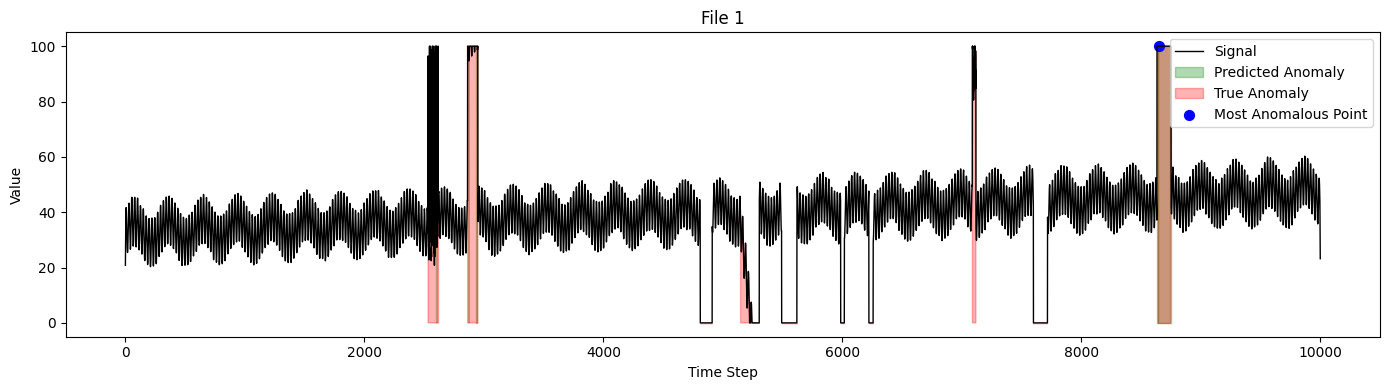

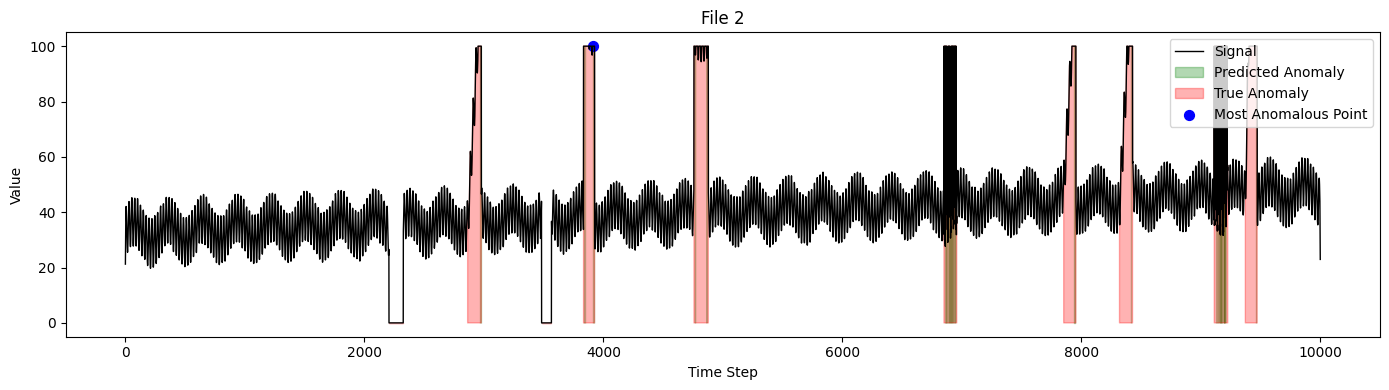

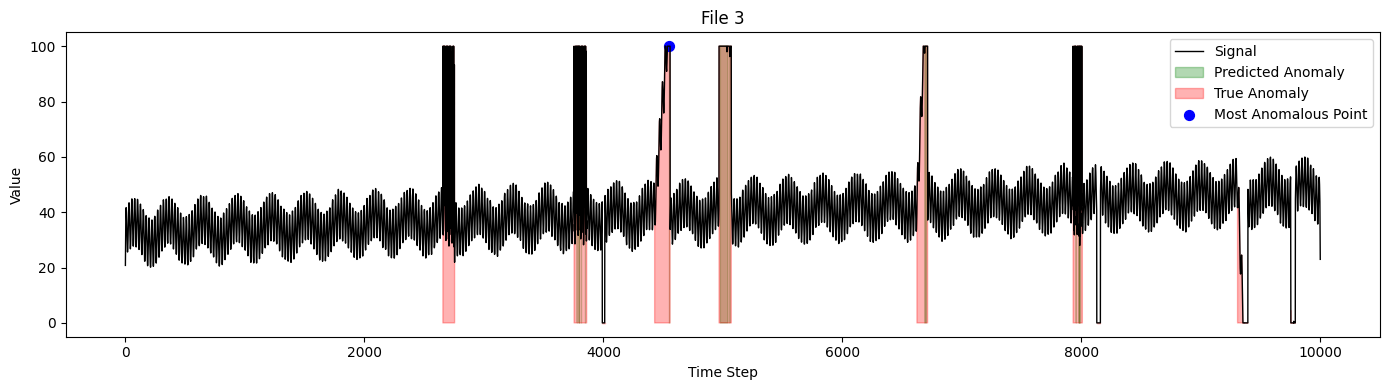

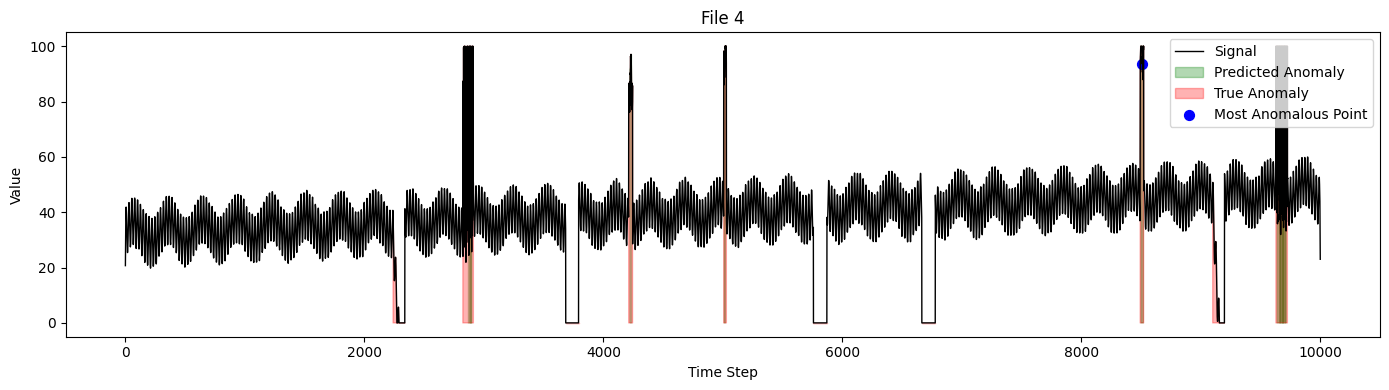

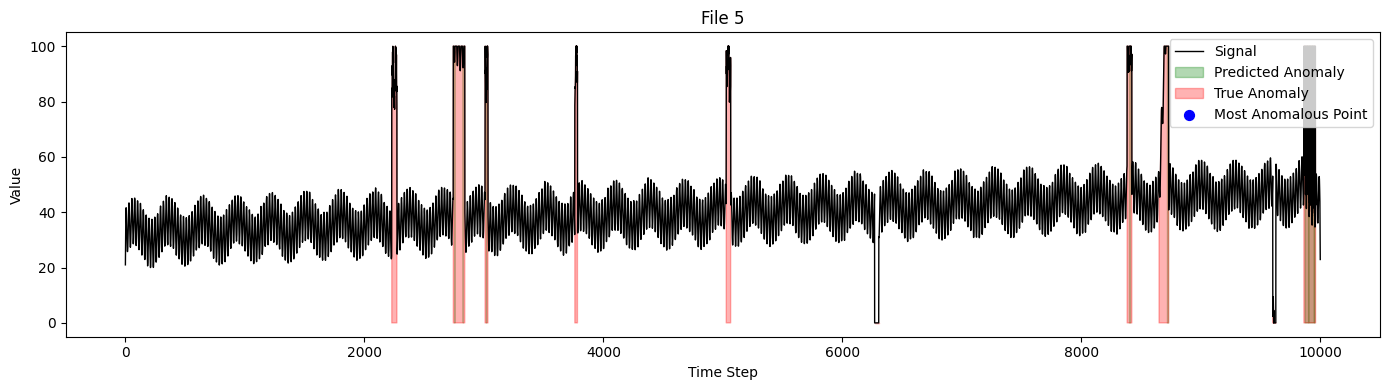

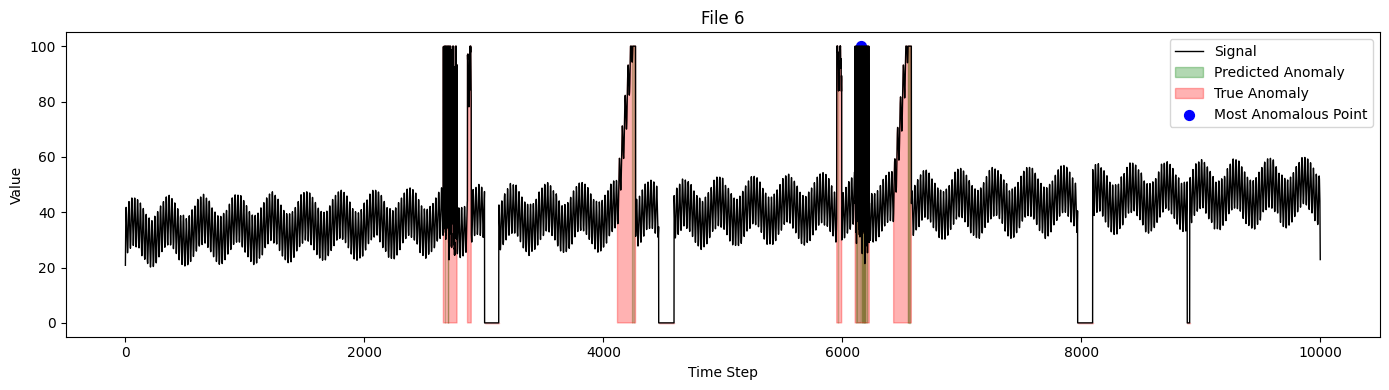

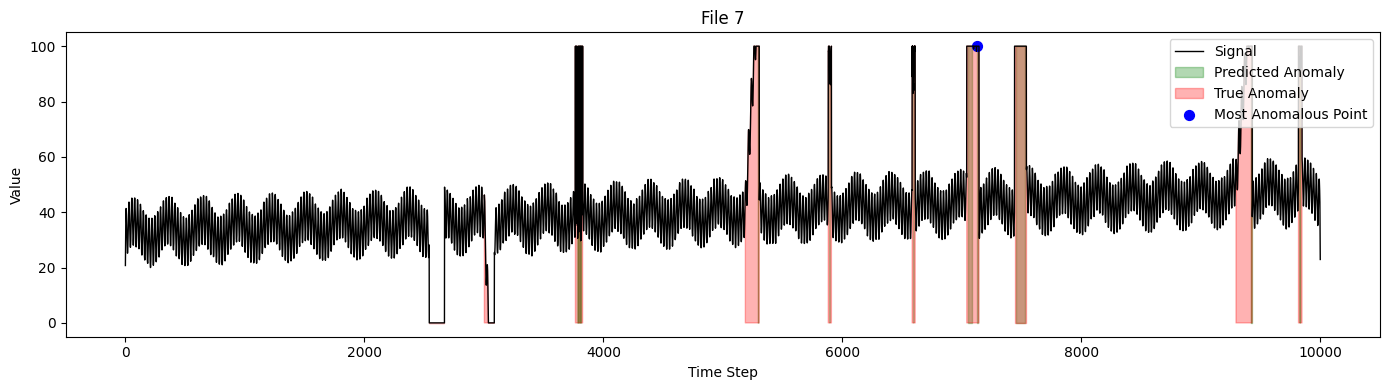

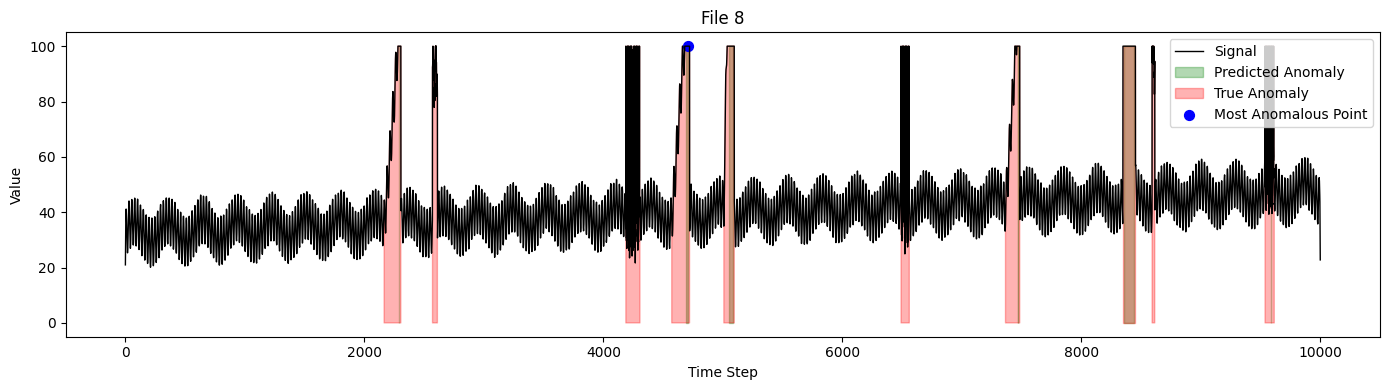

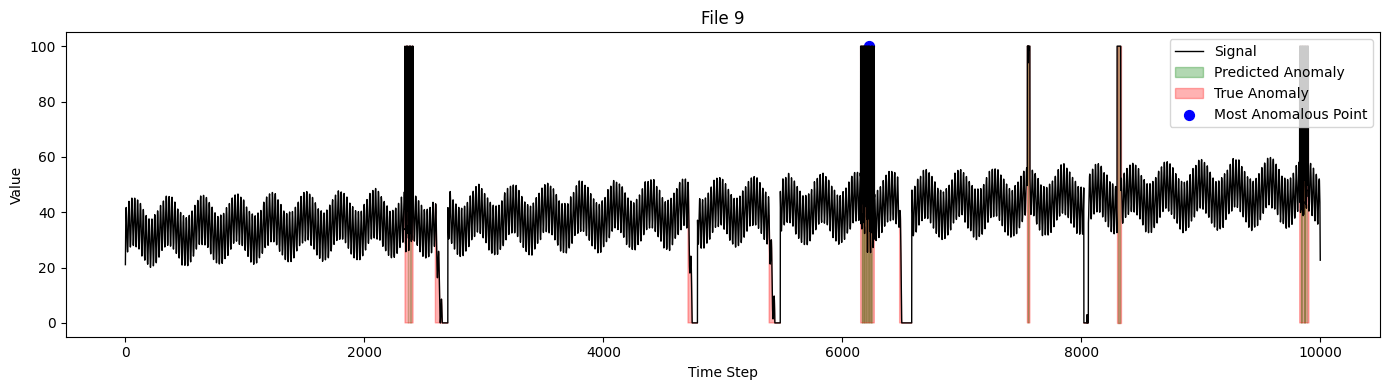

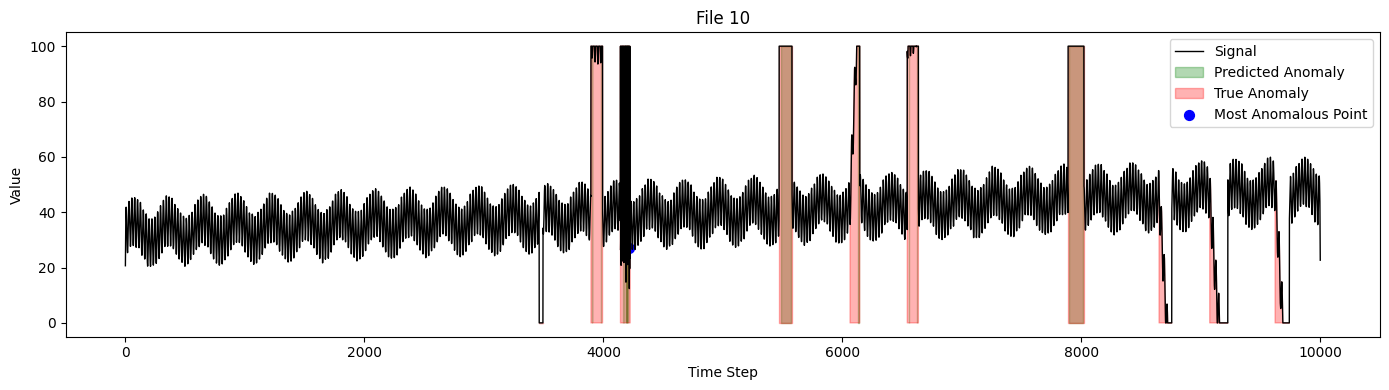

In [10]:
def visualize_anomaly_detection(test_df, model, file_idx=None):
    """
    Visualizes:
    - Signal (black)
    - Ground truth anomalies (red)
    - Predicted anomalies (green)
    - Most anomalous index (blue dot)
    """
    series = test_df['Value1'].to_numpy()
    true_mask = test_df['Labels'].to_numpy().astype(bool)
    pred_mask = model.full_anomaly_mask.astype(bool)
    most_anomalous = np.argmin(pred_mask) if pred_mask.any() else None
    pred_index = model.predict(series)  # triggers .full_anomaly_mask

    plt.figure(figsize=(14, 4))
    plt.plot(series, color='black', lw=1, label='Signal')

    if pred_mask.any():
        plt.fill_between(np.arange(len(series)), series,
                         where=pred_mask, color='green', alpha=0.3,
                         label='Predicted Anomaly')

    if true_mask.any():
        plt.fill_between(np.arange(len(series)), series,
                         where=true_mask, color='red', alpha=0.3,
                         label='True Anomaly')

    if 0 <= pred_index < len(series):
        plt.scatter(pred_index, series[pred_index], color='blue', s=50, label='Most Anomalous Point')

    title = f"File {file_idx}" if file_idx is not None else "Anomaly Detection"
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


# -- Loop over all files and visualize each --
for idx, (train, test) in enumerate(zip(train_files, test_files), 1):
    model = AnomalyDetectionModel(window_size=30, contamination=0.01)
    model.fit(train['Value1'].to_numpy(), train['Labels'].to_numpy())
    model.predict(test['Value1'].to_numpy())  # sets .full_anomaly_mask
    visualize_anomaly_detection(test, model, file_idx=idx)

# **ARIMA Model**

**This is what has been done to the ARIMA model:**
- Automatic Parameter Tuning: Grid search for optimal (p,d,q) parameters using AIC criterion

- Stationarity Check: Uses Augmented Dickey-Fuller test to determine if differencing is needed

- Confidence Intervals: Uses prediction confidence intervals for anomaly detection

- Residual Analysis: Detects anomalies based on large residuals

- Comprehensive Visualization: Shows predictions, confidence intervals, and residuals

- Preprocessing & Hyperparameter Tuning:
Stationarity handling: Automatic differencing (d parameter)

- Parameter ranges: Configurable search space for p, d, q

- AIC optimization: Selects best model based on Akaike Information Criterion

- Confidence level tuning: Adjustable confidence intervals for sensitivity control

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class ARIMAAnomalyDetection:
    def __init__(self, p_range=(0, 3), d_range=(0, 2), q_range=(0, 3), confidence_level=0.95):
        self.p_range = p_range
        self.d_range = d_range
        self.q_range = q_range
        self.confidence_level = confidence_level
        self.best_params = None
        self.best_model = None
        self.residuals = None
        self.full_anomaly_mask = None

    def check_stationarity(self, series):
        """Check if series is stationary using Augmented Dickey-Fuller test"""
        result = adfuller(series.dropna())
        return result[1] <= 0.05  # p-value <= 0.05 indicates stationarity

    def difference_series(self, series, d):
        """Difference the series d times to make it stationary"""
        diff_series = series.copy()
        for _ in range(d):
            diff_series = diff_series.diff().dropna()
        return diff_series

    def find_best_arima_params(self, series):
        """Find optimal ARIMA parameters using grid search with AIC"""
        best_aic = np.inf
        best_order = (0, 0, 0)

        # Try different combinations of p, d, q
        for p in range(self.p_range[0], self.p_range[1] + 1):
            for d in range(self.d_range[0], self.d_range[1] + 1):
                for q in range(self.q_range[0], self.q_range[1] + 1):
                    try:
                        # Handle stationarity
                        if d > 0:
                            temp_series = self.difference_series(series, d)
                            if len(temp_series) < 10:  # Too short after differencing
                                continue
                        else:
                            temp_series = series

                        # Fit ARIMA model
                        model = ARIMA(temp_series, order=(p, 0, q))
                        fitted_model = model.fit()

                        # Update best model if AIC is better
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_order = (p, d, q)
                            self.best_model = fitted_model

                    except Exception as e:
                        continue

        self.best_params = best_order
        return best_order

    def fit(self, series):
        """Fit the ARIMA model to the training data"""
        series = pd.Series(series).reset_index(drop=True)

        # Find best parameters
        best_order = self.find_best_arima_params(series)
        print(f"Best ARIMA parameters: {best_order}")

        # Refit model with best parameters on original series
        if best_order[1] > 0:  # If differencing needed
            diff_series = self.difference_series(series, best_order[1])
            model = ARIMA(diff_series, order=(best_order[0], 0, best_order[2]))
        else:
            model = ARIMA(series, order=best_order)

        self.best_model = model.fit()
        self.residuals = self.best_model.resid

        return self

    def predict_with_confidence(self, series):
        """Make predictions with confidence intervals"""
        series = pd.Series(series).reset_index(drop=True)

        # Use the best parameters to make predictions
        if self.best_params[1] > 0:
            diff_series = self.difference_series(series, self.best_params[1])
            model = ARIMA(diff_series, order=(self.best_params[0], 0, self.best_params[2]))
        else:
            model = ARIMA(series, order=self.best_params)

        fitted_model = model.fit()

        # Get predictions and confidence intervals
        forecast = fitted_model.get_forecast(steps=len(series))
        pred_mean = forecast.predicted_mean
        conf_int = forecast.conf_int(alpha=1-self.confidence_level)

        return pred_mean, conf_int

    def detect_anomalies(self, series):
        """Detect anomalies using prediction errors and confidence intervals"""
        pred_mean, conf_int = self.predict_with_confidence(series)

        # Calculate prediction errors
        if self.best_params[1] > 0:
            actual_series = self.difference_series(pd.Series(series), self.best_params[1])
        else:
            actual_series = pd.Series(series)

        # Align lengths
        min_len = min(len(actual_series), len(pred_mean))
        actual_series = actual_series.iloc[:min_len]
        pred_mean = pred_mean.iloc[:min_len]
        conf_int = conf_int.iloc[:min_len]

        # Calculate residuals
        residuals = actual_series.values - pred_mean.values

        # Detect anomalies: points outside confidence intervals or with large residuals
        lower_bound = conf_int.iloc[:, 0].values
        upper_bound = conf_int.iloc[:, 1].values

        # Points outside confidence intervals
        outside_ci = (actual_series.values < lower_bound) | (actual_series.values > upper_bound)

        # Points with large residuals (more than 2 standard deviations)
        residual_std = np.std(residuals)
        large_residuals = np.abs(residuals) > 2 * residual_std

        # Combined anomaly detection
        anomaly_mask = outside_ci | large_residuals

        # Convert to full-length mask
        full_mask = np.zeros(len(series), dtype=bool)
        if self.best_params[1] > 0:
            # For differenced series, we need to adjust indices
            full_mask[self.best_params[1]:self.best_params[1] + len(anomaly_mask)] = anomaly_mask
        else:
            full_mask[:len(anomaly_mask)] = anomaly_mask

        self.full_anomaly_mask = full_mask.astype(int)

        return self.full_anomaly_mask

def student_detect_anomalies(series: np.ndarray) -> list:
    """
    ARIMA-based anomaly detection
    Input: series: 1D array-like of floats (test series)
    Output: List of (start, end) index pairs for anomaly ranges
    """
    x = np.asarray(series, dtype=float)

    if len(x) == 0:
        return []

    # Initialize and fit ARIMA model
    arima_detector = ARIMAAnomalyDetection(
        p_range=(0, 2),  # AR order
        d_range=(0, 1),  # Differencing order
        q_range=(0, 2),  # MA order
        confidence_level=0.99  # 99% confidence interval
    )

    # Fit model (using the series itself since we don't have separate training in this context)
    arima_detector.fit(x)

    # Detect anomalies
    anomaly_mask = arima_detector.detect_anomalies(x)

    # Convert mask to ranges
    anomalies = []
    in_anomaly = False
    start_idx = 0

    for i, is_anomaly in enumerate(anomaly_mask):
        if is_anomaly and not in_anomaly:
            start_idx = i
            in_anomaly = True
        elif not is_anomaly and in_anomaly:
            anomalies.append((start_idx, i-1))
            in_anomaly = False

    # Handle case where anomaly continues until end
    if in_anomaly:
        anomalies.append((start_idx, len(anomaly_mask)-1))

    print(f"ARIMA Model Parameters: {arima_detector.best_params}")
    print(f"Anomalies identified: {len(anomalies)} segments")

    return anomalies

# Visualization function for ARIMA results
def visualize_arima_anomalies(test_df, arima_detector, file_idx=None):
    """Visualize ARIMA anomaly detection results"""
    series = test_df['Value1'].to_numpy()
    true_mask = test_df['Labels'].to_numpy().astype(bool)
    pred_mask = arima_detector.full_anomaly_mask.astype(bool)

    # Get predictions for plotting
    pred_mean, conf_int = arima_detector.predict_with_confidence(series)

    plt.figure(figsize=(14, 8))

    # Plot original series
    plt.subplot(2, 1, 1)
    plt.plot(series, color='black', lw=1, label='Signal')

    # Plot predictions
    if len(pred_mean) > 0:
        pred_x = range(len(pred_mean))
        if arima_detector.best_params[1] > 0:
            pred_x = range(arima_detector.best_params[1],
                          arima_detector.best_params[1] + len(pred_mean))
        plt.plot(pred_x, pred_mean, color='blue', alpha=0.7, label='ARIMA Prediction')
        plt.fill_between(pred_x,
                        conf_int.iloc[:, 0],
                        conf_int.iloc[:, 1],
                        color='blue', alpha=0.2, label='Confidence Interval')

    # Plot anomalies
    if pred_mask.any():
        anomaly_indices = np.where(pred_mask)[0]
        plt.scatter(anomaly_indices, series[anomaly_indices],
                   color='red', s=30, label='Detected Anomalies', zorder=5)

    if true_mask.any():
        plt.fill_between(range(len(series)), np.min(series), np.max(series),
                        where=true_mask, color='green', alpha=0.3, label='True Anomalies')

    title = f"ARIMA Anomaly Detection - File {file_idx}" if file_idx is not None else "ARIMA Anomaly Detection"
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot residuals
    plt.subplot(2, 1, 2)
    if hasattr(arima_detector.best_model, 'resid') and arima_detector.best_model.resid is not None:
        residuals = arima_detector.best_model.resid
        plt.plot(residuals, color='red', alpha=0.7, label='Residuals')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.axhline(y=2*np.std(residuals), color='orange', linestyle='--', alpha=0.7, label='±2σ')
        plt.axhline(y=-2*np.std(residuals), color='orange', linestyle='--', alpha=0.7)
        plt.title('Model Residuals')
        plt.xlabel("Time Step")
        plt.ylabel("Residual")
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Testing ARIMA Anomaly Detection on all files...

--- Processing File 1 ---
Best ARIMA parameters: (2, 1, 2)
ARIMA Model Parameters: (2, 1, 2)
Anomalies identified: 35 segments
Anomaly 1: 2533-2534
Anomaly 2: 2539-2540
Anomaly 3: 2545-2546
Anomaly 4: 2551-2552
Anomaly 5: 2557-2558
Anomaly 6: 2563-2564
Anomaly 7: 2569-2570
Anomaly 8: 2575-2576
Anomaly 9: 2581-2582
Anomaly 10: 2586-2588
Anomaly 11: 2593-2594
Anomaly 12: 2599-2600
Anomaly 13: 2605-2606
Anomaly 14: 2611-2612
Anomaly 15: 2617-2618
Anomaly 16: 2864-2864
Anomaly 17: 2950-2950
Anomaly 18: 4811-4811
Anomaly 19: 4911-4911
Anomaly 20: 5305-5305
Anomaly 21: 5492-5492
Anomaly 22: 5620-5620
Anomaly 23: 5986-5986
Anomaly 24: 6017-6017
Anomaly 25: 6222-6222
Anomaly 26: 6258-6258
Anomaly 27: 7088-7088
Anomaly 28: 7094-7094
Anomaly 29: 7104-7104
Anomaly 30: 7114-7116
Anomaly 31: 7118-7118
Anomaly 32: 7599-7599
Anomaly 33: 7717-7717
Anomaly 34: 8633-8633
Anomaly 35: 8751-8751
Best ARIMA parameters: (3, 1, 3)


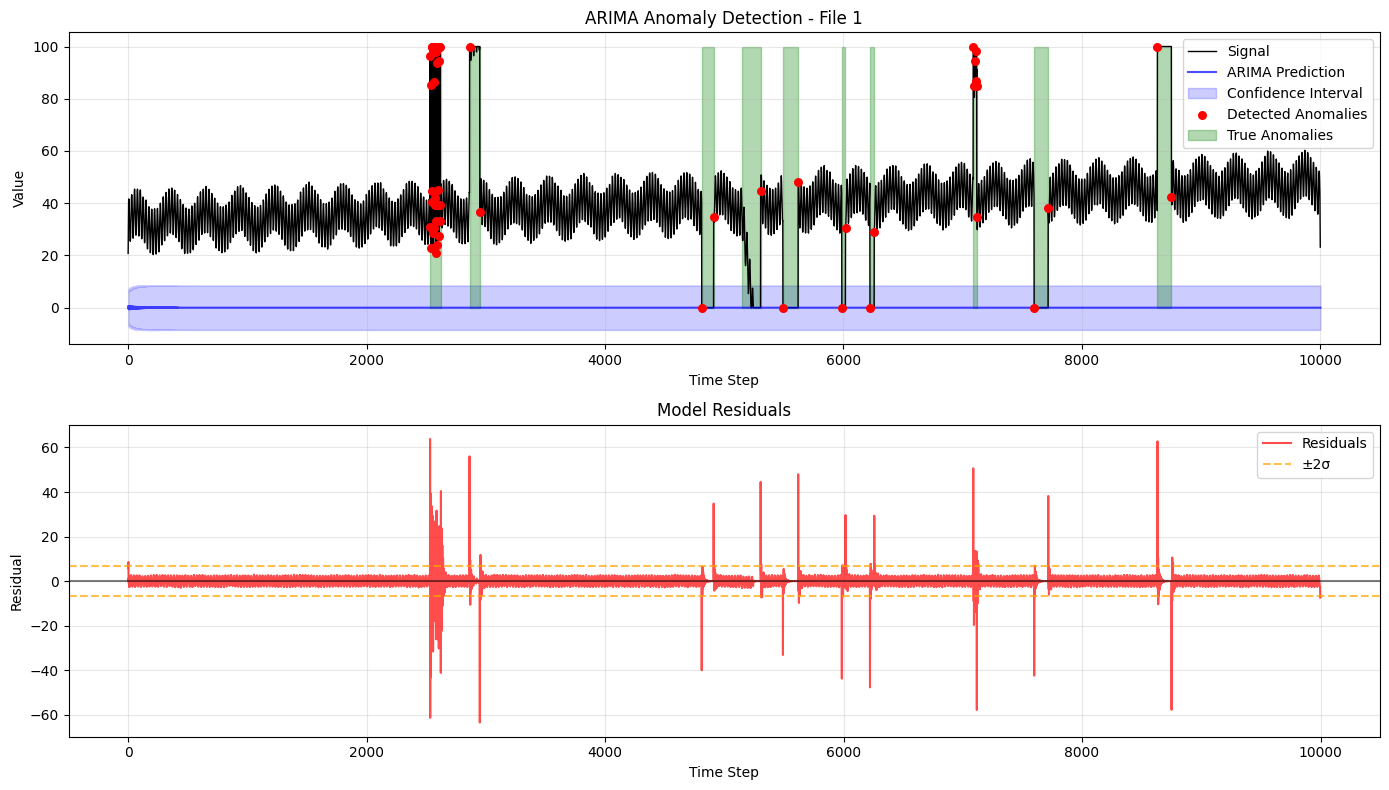


--- Processing File 2 ---
Best ARIMA parameters: (2, 1, 2)
ARIMA Model Parameters: (2, 1, 2)
Anomalies identified: 49 segments
Anomaly 1: 2206-2206
Anomaly 2: 2326-2326
Anomaly 3: 2979-2979
Anomaly 4: 3483-3483
Anomaly 5: 3566-3566
Anomaly 6: 3834-3834
Anomaly 7: 3927-3927
Anomaly 8: 4758-4758
Anomaly 9: 4879-4879
Anomaly 10: 6850-6851
Anomaly 11: 6856-6857
Anomaly 12: 6862-6863
Anomaly 13: 6868-6869
Anomaly 14: 6874-6875
Anomaly 15: 6880-6881
Anomaly 16: 6886-6887
Anomaly 17: 6892-6893
Anomaly 18: 6898-6899
Anomaly 19: 6904-6905
Anomaly 20: 6910-6911
Anomaly 21: 6916-6917
Anomaly 22: 6922-6923
Anomaly 23: 6928-6929
Anomaly 24: 6934-6935
Anomaly 25: 6940-6941
Anomaly 26: 6946-6947
Anomaly 27: 6952-6953
Anomaly 28: 7955-7955
Anomaly 29: 8429-8429
Anomaly 30: 9112-9113
Anomaly 31: 9118-9119
Anomaly 32: 9124-9125
Anomaly 33: 9130-9131
Anomaly 34: 9136-9137
Anomaly 35: 9142-9143
Anomaly 36: 9148-9149
Anomaly 37: 9154-9155
Anomaly 38: 9160-9161
Anomaly 39: 9166-9167
Anomaly 40: 9172-9173
A

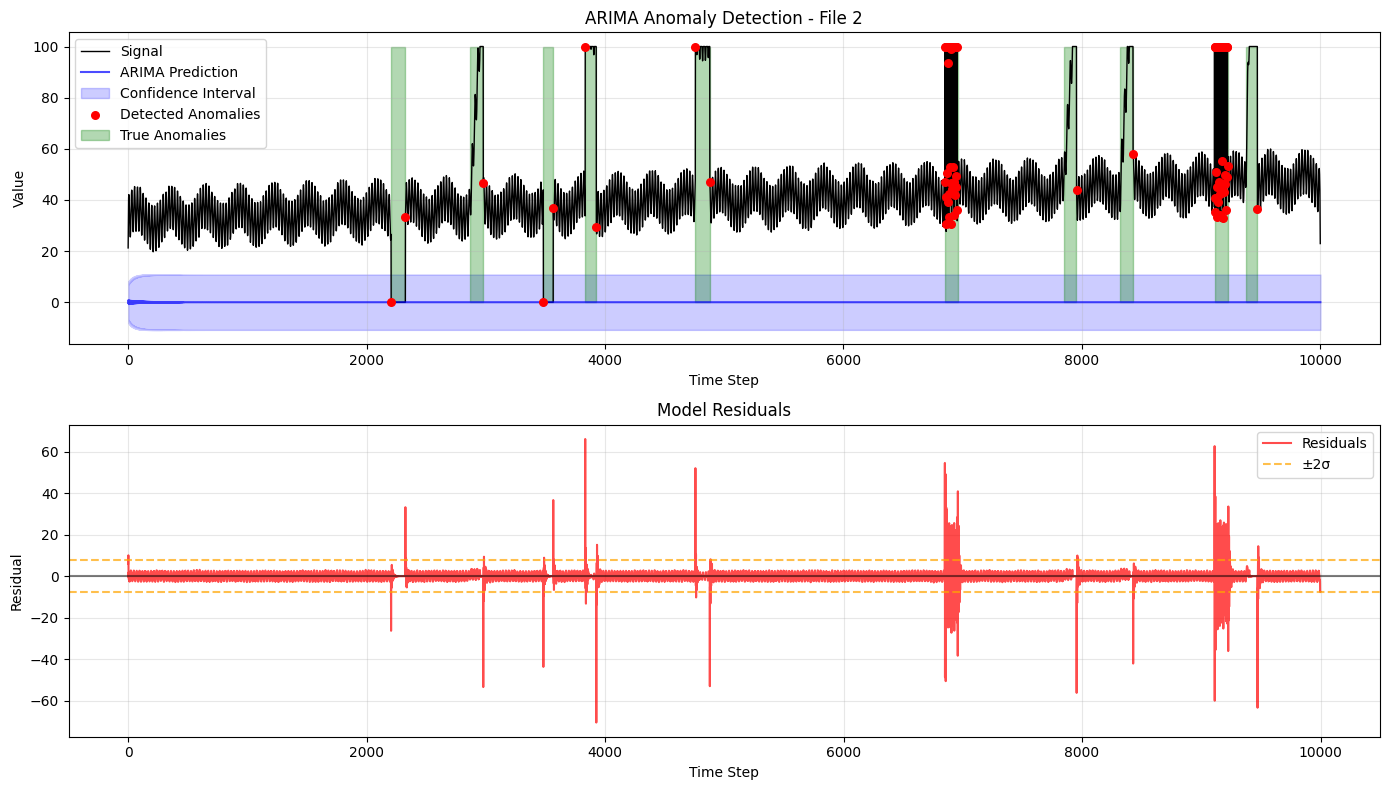


--- Processing File 3 ---
Best ARIMA parameters: (2, 1, 2)
ARIMA Model Parameters: (2, 1, 2)
Anomalies identified: 59 segments
Anomaly 1: 2657-2658
Anomaly 2: 2663-2664
Anomaly 3: 2669-2670
Anomaly 4: 2675-2676
Anomaly 5: 2681-2682
Anomaly 6: 2687-2688
Anomaly 7: 2693-2694
Anomaly 8: 2699-2700
Anomaly 9: 2705-2706
Anomaly 10: 2711-2712
Anomaly 11: 2717-2718
Anomaly 12: 2723-2724
Anomaly 13: 2729-2730
Anomaly 14: 2735-2736
Anomaly 15: 2741-2742
Anomaly 16: 2747-2748
Anomaly 17: 2753-2754
Anomaly 18: 3755-3756
Anomaly 19: 3761-3762
Anomaly 20: 3767-3768
Anomaly 21: 3773-3774
Anomaly 22: 3779-3780
Anomaly 23: 3785-3786
Anomaly 24: 3791-3792
Anomaly 25: 3797-3798
Anomaly 26: 3803-3804
Anomaly 27: 3809-3810
Anomaly 28: 3815-3816
Anomaly 29: 3821-3822
Anomaly 30: 3827-3828
Anomaly 31: 3833-3834
Anomaly 32: 3839-3840
Anomaly 33: 3845-3846
Anomaly 34: 3851-3852
Anomaly 35: 3857-3858
Anomaly 36: 3991-3991
Anomaly 37: 4012-4012
Anomaly 38: 4559-4559
Anomaly 39: 4968-4968
Anomaly 40: 5071-5071
A

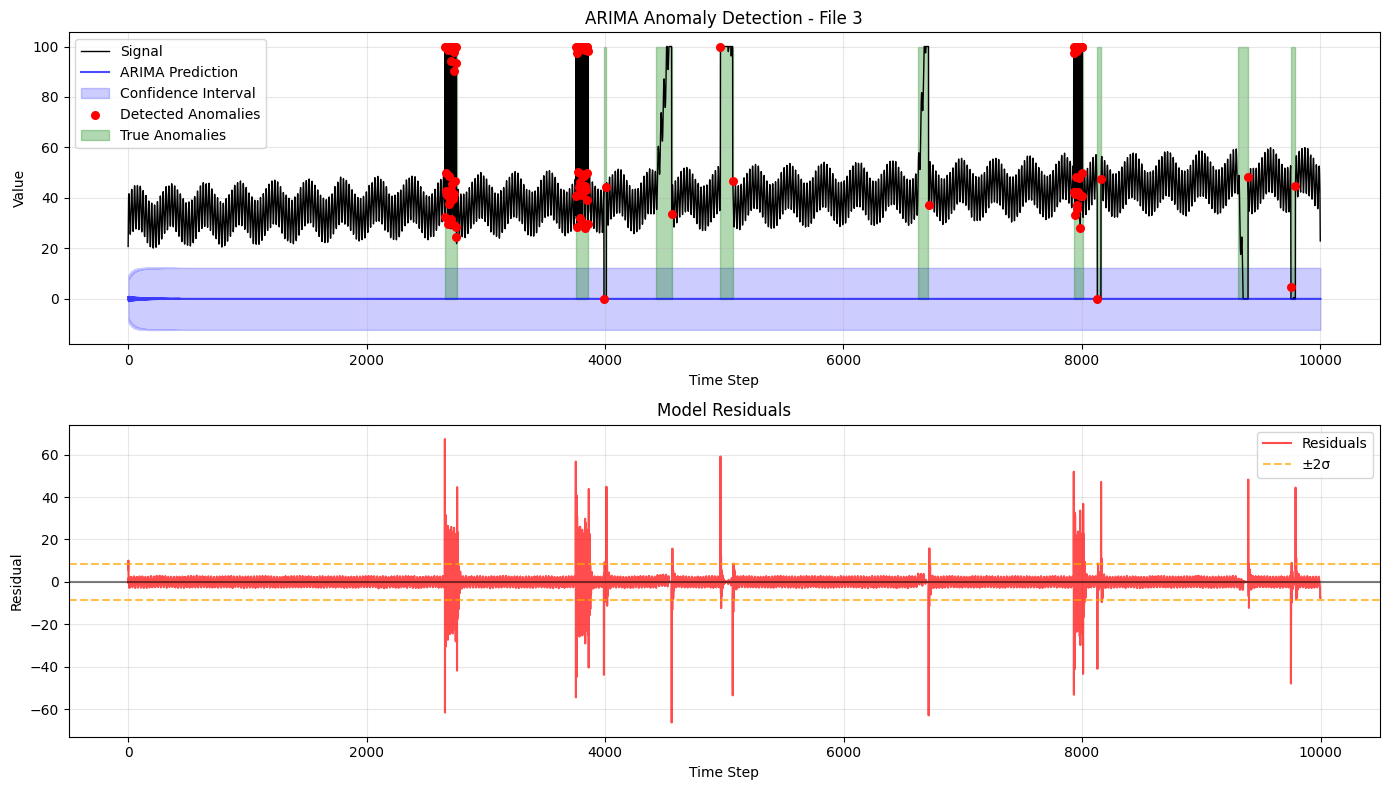


--- Processing File 4 ---
Best ARIMA parameters: (2, 1, 2)
ARIMA Model Parameters: (2, 1, 2)
Anomalies identified: 49 segments
Anomaly 1: 2339-2339
Anomaly 2: 2824-2825
Anomaly 3: 2830-2831
Anomaly 4: 2836-2837
Anomaly 5: 2842-2843
Anomaly 6: 2848-2849
Anomaly 7: 2854-2855
Anomaly 8: 2860-2861
Anomaly 9: 2866-2867
Anomaly 10: 2872-2873
Anomaly 11: 2878-2879
Anomaly 12: 2884-2885
Anomaly 13: 2890-2891
Anomaly 14: 2896-2897
Anomaly 15: 2902-2903
Anomaly 16: 2908-2909
Anomaly 17: 3685-3685
Anomaly 18: 3793-3793
Anomaly 19: 4212-4212
Anomaly 20: 4221-4221
Anomaly 21: 4245-4245
Anomaly 22: 5007-5008
Anomaly 23: 5030-5030
Anomaly 24: 5758-5758
Anomaly 25: 5871-5871
Anomaly 26: 6665-6665
Anomaly 27: 6778-6778
Anomaly 28: 8492-8492
Anomaly 29: 8522-8522
Anomaly 30: 9198-9198
Anomaly 31: 9628-9630
Anomaly 32: 9634-9635
Anomaly 33: 9640-9641
Anomaly 34: 9646-9647
Anomaly 35: 9652-9653
Anomaly 36: 9658-9659
Anomaly 37: 9664-9665
Anomaly 38: 9670-9671
Anomaly 39: 9673-9673
Anomaly 40: 9676-9677
A

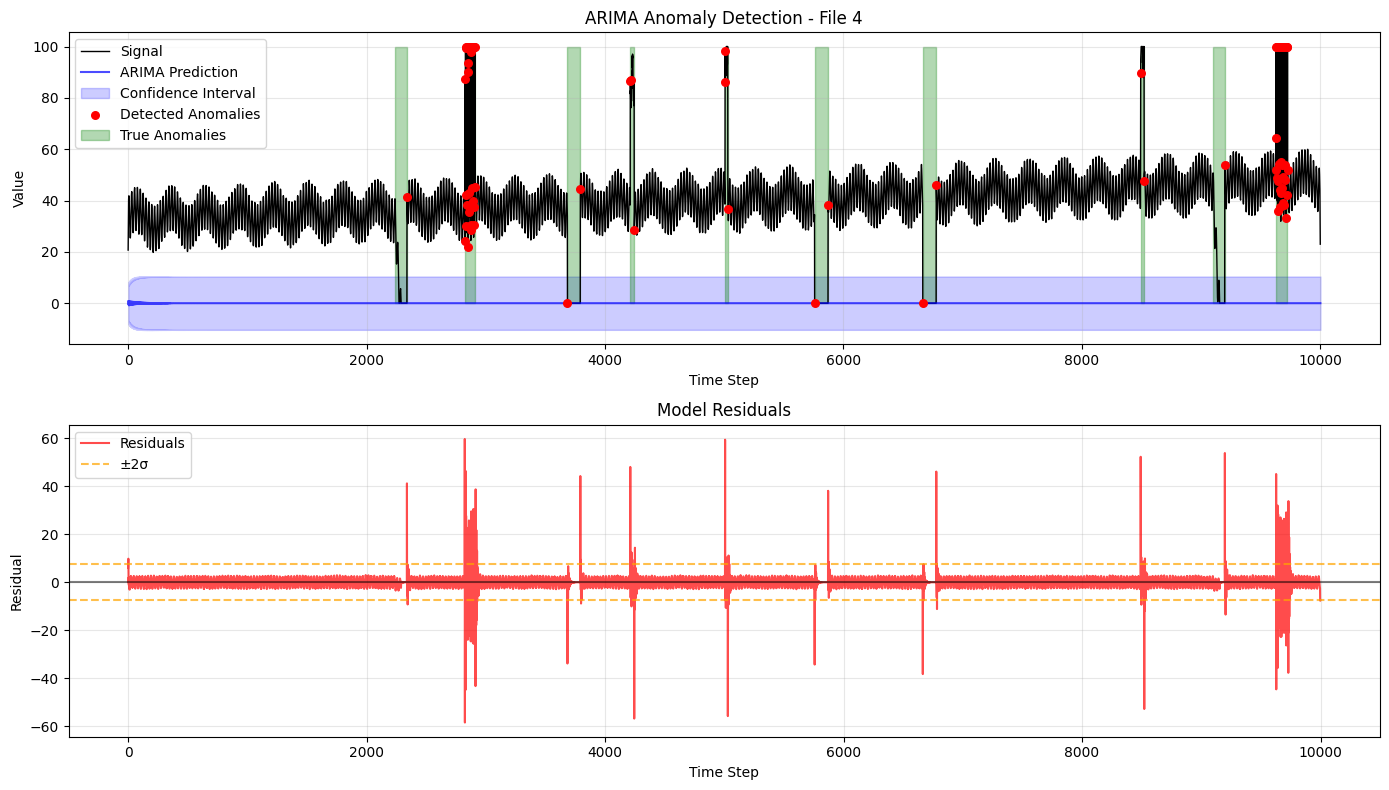


--- Processing File 5 ---
Best ARIMA parameters: (2, 1, 2)
ARIMA Model Parameters: (2, 1, 2)
Anomalies identified: 45 segments
Anomaly 1: 2229-2229
Anomaly 2: 2233-2233
Anomaly 3: 2242-2242
Anomaly 4: 2254-2254
Anomaly 5: 2269-2269
Anomaly 6: 2273-2273
Anomaly 7: 2744-2744
Anomaly 8: 2841-2841
Anomaly 9: 3010-3010
Anomaly 10: 3021-3021
Anomaly 11: 3035-3035
Anomaly 12: 3761-3761
Anomaly 13: 3782-3782
Anomaly 14: 3784-3784
Anomaly 15: 5028-5028
Anomaly 16: 5030-5030
Anomaly 17: 5037-5037
Anomaly 18: 5055-5055
Anomaly 19: 5064-5064
Anomaly 20: 5066-5066
Anomaly 21: 6270-6270
Anomaly 22: 6305-6305
Anomaly 23: 8383-8383
Anomaly 24: 8423-8423
Anomaly 25: 8731-8731
Anomaly 26: 9602-9602
Anomaly 27: 9628-9628
Anomaly 28: 9862-9863
Anomaly 29: 9868-9869
Anomaly 30: 9874-9876
Anomaly 31: 9880-9881
Anomaly 32: 9886-9887
Anomaly 33: 9892-9893
Anomaly 34: 9898-9899
Anomaly 35: 9904-9905
Anomaly 36: 9910-9911
Anomaly 37: 9913-9913
Anomaly 38: 9916-9917
Anomaly 39: 9922-9923
Anomaly 40: 9928-9929
A

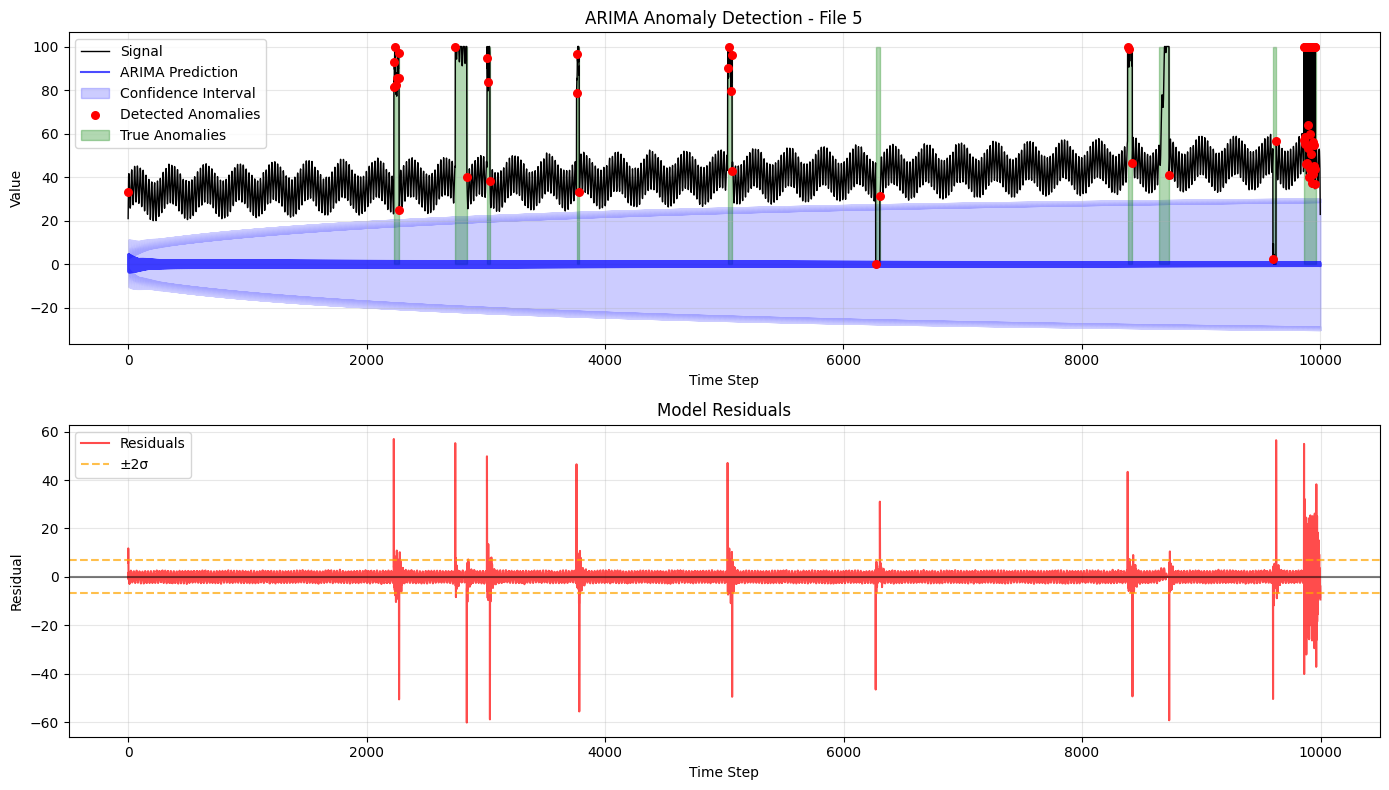


--- Processing File 6 ---
Best ARIMA parameters: (2, 1, 2)
ARIMA Model Parameters: (2, 1, 2)
Anomalies identified: 59 segments
Anomaly 1: 2661-2662
Anomaly 2: 2667-2668
Anomaly 3: 2673-2674
Anomaly 4: 2679-2680
Anomaly 5: 2685-2686
Anomaly 6: 2691-2692
Anomaly 7: 2697-2698
Anomaly 8: 2703-2704
Anomaly 9: 2709-2710
Anomaly 10: 2715-2716
Anomaly 11: 2721-2722
Anomaly 12: 2727-2728
Anomaly 13: 2733-2734
Anomaly 14: 2739-2740
Anomaly 15: 2745-2746
Anomaly 16: 2751-2752
Anomaly 17: 2757-2758
Anomaly 18: 2763-2764
Anomaly 19: 2769-2770
Anomaly 20: 2775-2776
Anomaly 21: 2863-2863
Anomaly 22: 2895-2895
Anomaly 23: 3006-3006
Anomaly 24: 3125-3125
Anomaly 25: 4270-4270
Anomaly 26: 4463-4463
Anomaly 27: 4592-4592
Anomaly 28: 5953-5953
Anomaly 29: 5995-5995
Anomaly 30: 6107-6108
Anomaly 31: 6113-6114
Anomaly 32: 6119-6120
Anomaly 33: 6122-6122
Anomaly 34: 6124-6126
Anomaly 35: 6129-6132
Anomaly 36: 6137-6138
Anomaly 37: 6143-6144
Anomaly 38: 6147-6151
Anomaly 39: 6154-6156
Anomaly 40: 6161-6164
A

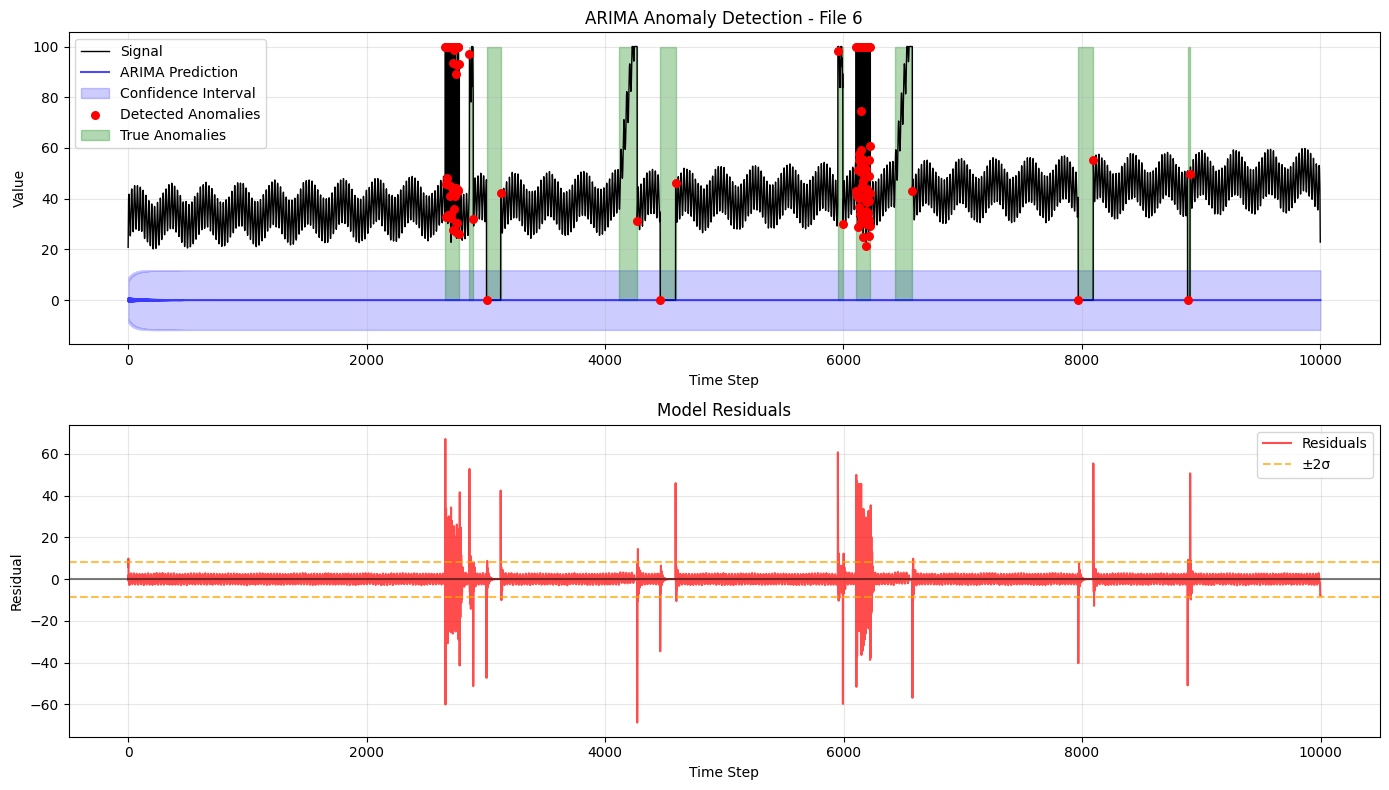


--- Processing File 7 ---
Best ARIMA parameters: (2, 0, 1)
ARIMA Model Parameters: (2, 0, 1)
Anomalies identified: 21 segments
Anomaly 1: 2543-2670
Anomaly 2: 3035-3087
Anomaly 3: 3766-3766
Anomaly 4: 3772-3772
Anomaly 5: 3778-3778
Anomaly 6: 3784-3784
Anomaly 7: 3790-3790
Anomaly 8: 3796-3796
Anomaly 9: 3802-3802
Anomaly 10: 3808-3808
Anomaly 11: 3814-3814
Anomaly 12: 3820-3820
Anomaly 13: 3826-3826
Anomaly 14: 5232-5304
Anomaly 15: 5882-5908
Anomaly 16: 6584-6609
Anomaly 17: 7041-7143
Anomaly 18: 7441-7539
Anomaly 19: 9319-9320
Anomaly 20: 9336-9429
Anomaly 21: 9817-9846
Best ARIMA parameters: (3, 1, 3)


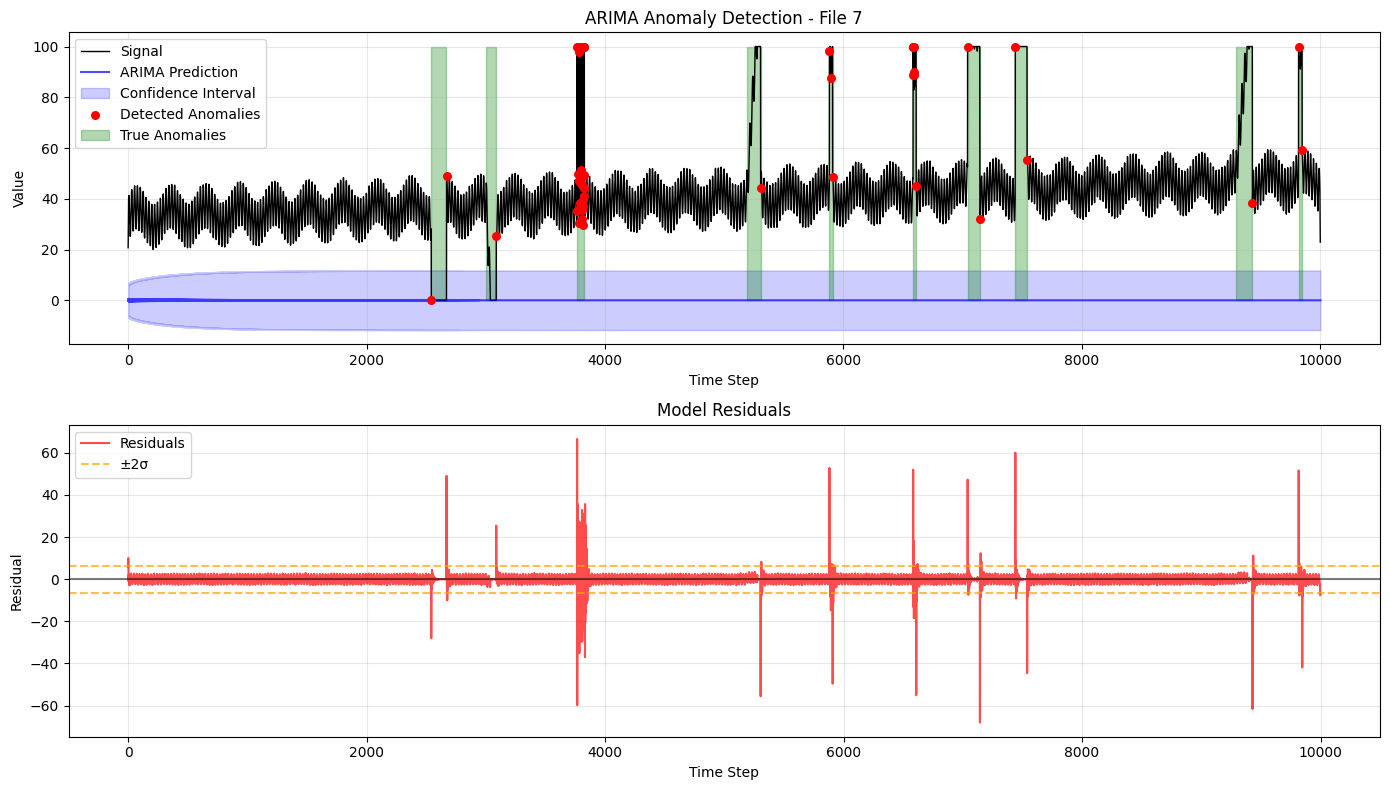


--- Processing File 8 ---
Best ARIMA parameters: (2, 1, 2)
ARIMA Model Parameters: (2, 1, 2)
Anomalies identified: 55 segments
Anomaly 1: 2306-2306
Anomaly 2: 2570-2570
Anomaly 3: 2612-2612
Anomaly 4: 4188-4189
Anomaly 5: 4194-4195
Anomaly 6: 4200-4201
Anomaly 7: 4206-4207
Anomaly 8: 4212-4213
Anomaly 9: 4218-4219
Anomaly 10: 4224-4225
Anomaly 11: 4230-4231
Anomaly 12: 4236-4237
Anomaly 13: 4242-4243
Anomaly 14: 4248-4249
Anomaly 15: 4254-4255
Anomaly 16: 4260-4261
Anomaly 17: 4266-4267
Anomaly 18: 4272-4273
Anomaly 19: 4278-4279
Anomaly 20: 4284-4285
Anomaly 21: 4290-4291
Anomaly 22: 4296-4297
Anomaly 23: 4302-4303
Anomaly 24: 4722-4722
Anomaly 25: 5096-5096
Anomaly 26: 6491-6492
Anomaly 27: 6497-6498
Anomaly 28: 6503-6504
Anomaly 29: 6509-6510
Anomaly 30: 6515-6516
Anomaly 31: 6521-6522
Anomaly 32: 6527-6528
Anomaly 33: 6533-6534
Anomaly 34: 6539-6540
Anomaly 35: 6545-6546
Anomaly 36: 6551-6552
Anomaly 37: 6557-6558
Anomaly 38: 7485-7485
Anomaly 39: 8348-8348
Anomaly 40: 8453-8453
A

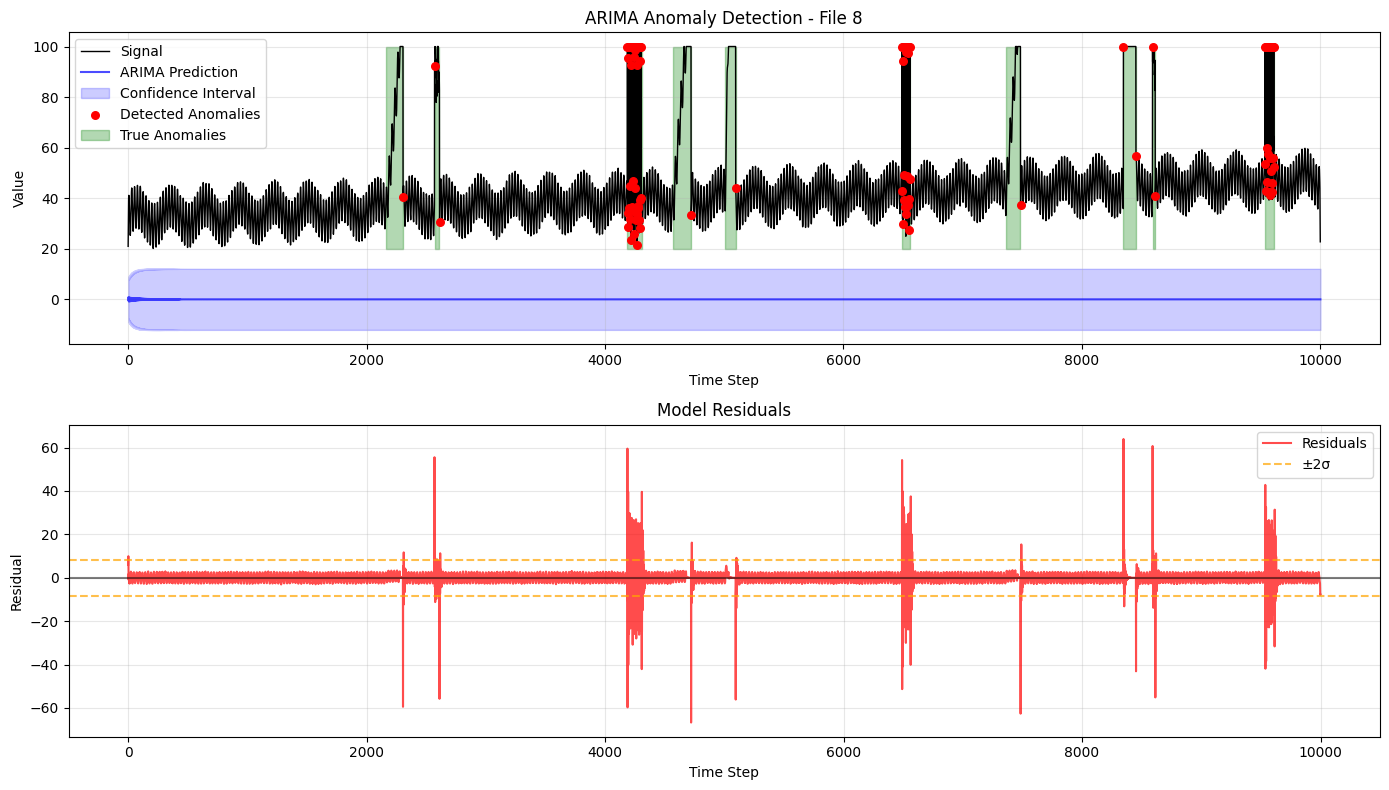


--- Processing File 9 ---
Best ARIMA parameters: (2, 1, 2)
ARIMA Model Parameters: (2, 1, 2)
Anomalies identified: 56 segments
Anomaly 1: 2340-2341
Anomaly 2: 2346-2347
Anomaly 3: 2352-2353
Anomaly 4: 2358-2359
Anomaly 5: 2364-2365
Anomaly 6: 2370-2371
Anomaly 7: 2376-2377
Anomaly 8: 2382-2383
Anomaly 9: 2388-2389
Anomaly 10: 2394-2395
Anomaly 11: 2400-2401
Anomaly 12: 2406-2407
Anomaly 13: 2699-2699
Anomaly 14: 4788-4788
Anomaly 15: 5481-5481
Anomaly 16: 6153-6154
Anomaly 17: 6159-6160
Anomaly 18: 6165-6166
Anomaly 19: 6171-6172
Anomaly 20: 6177-6178
Anomaly 21: 6183-6184
Anomaly 22: 6189-6190
Anomaly 23: 6195-6196
Anomaly 24: 6201-6202
Anomaly 25: 6207-6208
Anomaly 26: 6213-6214
Anomaly 27: 6219-6220
Anomaly 28: 6225-6226
Anomaly 29: 6228-6228
Anomaly 30: 6231-6232
Anomaly 31: 6237-6238
Anomaly 32: 6243-6244
Anomaly 33: 6249-6250
Anomaly 34: 6255-6256
Anomaly 35: 6261-6262
Anomaly 36: 6267-6268
Anomaly 37: 6581-6581
Anomaly 38: 7548-7548
Anomaly 39: 7570-7570
Anomaly 40: 8021-8021
A

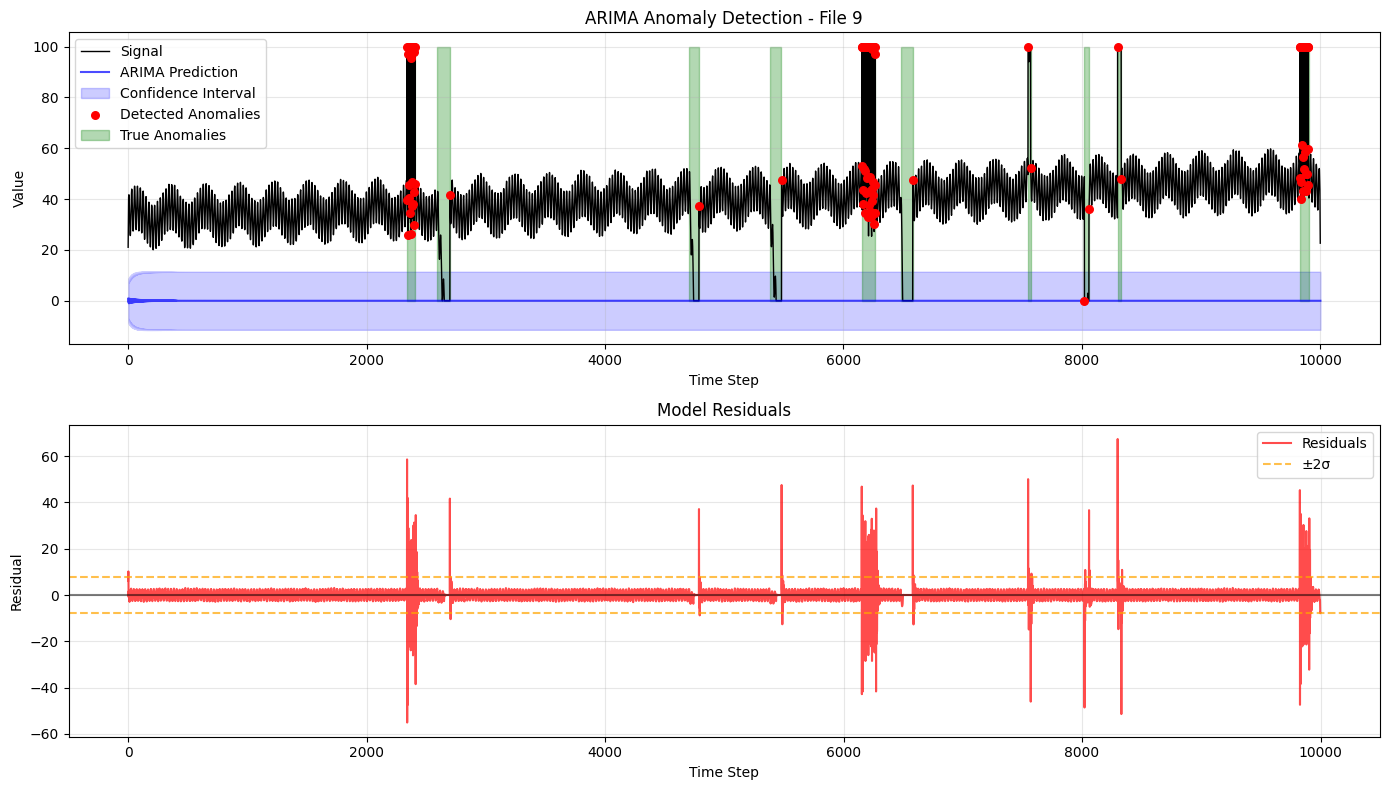


--- Processing File 10 ---
Best ARIMA parameters: (2, 1, 2)
ARIMA Model Parameters: (2, 1, 2)
Anomalies identified: 30 segments
Anomaly 1: 3463-3463
Anomaly 2: 3495-3495
Anomaly 3: 3896-3896
Anomaly 4: 3994-3994
Anomaly 5: 4143-4144
Anomaly 6: 4148-4151
Anomaly 7: 4154-4156
Anomaly 8: 4158-4159
Anomaly 9: 4161-4164
Anomaly 10: 4167-4168
Anomaly 11: 4173-4175
Anomaly 12: 4177-4181
Anomaly 13: 4185-4187
Anomaly 14: 4189-4192
Anomaly 15: 4194-4194
Anomaly 16: 4197-4198
Anomaly 17: 4200-4212
Anomaly 18: 4215-4219
Anomaly 19: 4221-4222
Anomaly 20: 4225-4225
Anomaly 21: 5471-5471
Anomaly 22: 5579-5579
Anomaly 23: 6146-6146
Anomaly 24: 6543-6543
Anomaly 25: 6637-6637
Anomaly 26: 7889-7889
Anomaly 27: 8022-8022
Anomaly 28: 8757-8757
Anomaly 29: 9226-9226
Anomaly 30: 9741-9741
Best ARIMA parameters: (3, 1, 3)


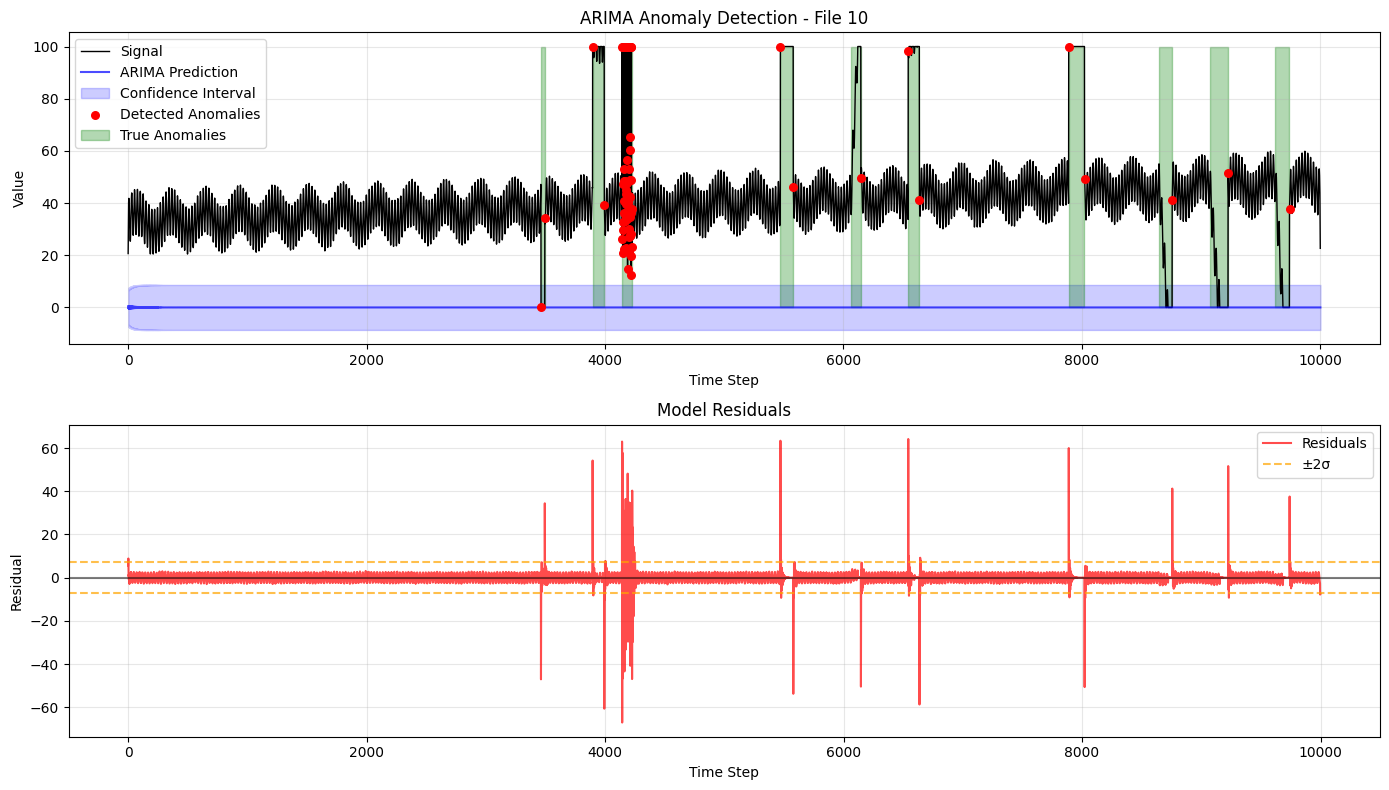

In [12]:
# Test the ARIMA detector on all files
print("Testing ARIMA Anomaly Detection on all files...")

for idx, test_file in enumerate(test_files, 1):
    print(f"\n--- Processing File {idx} ---")

    # Use student_detect_anomalies function
    series = test_file['Value1'].to_numpy()
    anomaly_ranges = student_detect_anomalies(series)

    # Print detected anomalies
    for i, (start, end) in enumerate(anomaly_ranges):
        print(f"Anomaly {i+1}: {start}-{end}")

    # Create ARIMA detector for visualization
    arima_detector = ARIMAAnomalyDetection()
    arima_detector.fit(series)
    arima_detector.detect_anomalies(series)

    # Visualize results
    visualize_arima_anomalies(test_file, arima_detector, file_idx=idx)

In [13]:
# Evaluation with ARIMA
print("\n--- ARIMA Model Evaluation ---")
correct = 0
total_files = len(test_files)

for idx, (train, test) in enumerate(zip(train_files, test_files), 1):
    try:
        # Fit ARIMA model on training data
        arima_detector = ARIMAAnomalyDetection()
        arima_detector.fit(train['Value1'].to_numpy())

        # Detect anomalies on test data
        anomaly_mask = arima_detector.detect_anomalies(test['Value1'].to_numpy())

        # Check if any detected anomalies match true labels
        true_anomalies = test['Labels'].to_numpy().astype(bool)
        detected_anomalies = anomaly_mask.astype(bool)

        # Simple evaluation: if any true anomaly is detected, count as correct
        if np.any(true_anomalies & detected_anomalies):
            correct += 1

    except Exception as e:
        print(f"Error processing file {idx}: {e}")
        continue

print(f"ARIMA Detection Accuracy: {correct}/{total_files} ({correct/total_files*100:.1f}%)")


--- ARIMA Model Evaluation ---
Best ARIMA parameters: (3, 1, 3)
Best ARIMA parameters: (3, 1, 3)
Best ARIMA parameters: (3, 1, 3)
Best ARIMA parameters: (3, 1, 3)
Best ARIMA parameters: (3, 1, 3)
Best ARIMA parameters: (3, 1, 3)
Best ARIMA parameters: (2, 1, 2)
Best ARIMA parameters: (3, 1, 3)
Best ARIMA parameters: (3, 1, 3)
Best ARIMA parameters: (3, 1, 3)
ARIMA Detection Accuracy: 10/10 (100.0%)


Starting comprehensive evaluation of ARIMA anomaly detection...
COMPREHENSIVE ARIMA ANOMALY DETECTION EVALUATION


Processing File 1...
Best ARIMA parameters: (3, 1, 3)

EVALUATION RESULTS - FILE 1
Basic Metrics:
  Accuracy:  0.9143
  Precision: 0.8302
  Recall:    0.0493
  F1-Score:  0.0931

Anomaly Statistics:
  True Anomalies: 892 points
  Predicted Anomalies: 53 points
  Detection Rate: 0.0493

Range-based Metrics:
  Range Precision: 0.8302
  Range Recall:    0.0493
  Range F1:        0.0819

Point-level Performance:
  True Positives:  44 points
  False Positives: 9 points
  False Negatives: 848 points

Segment Detection Metrics:
  Total Anomaly Segments: 10
  Fully Detected: 0
  Partially Detected: 9
  Missed: 1
  Segment Detection Rate: 0.0000
  Overall Detection Rate: 0.9000


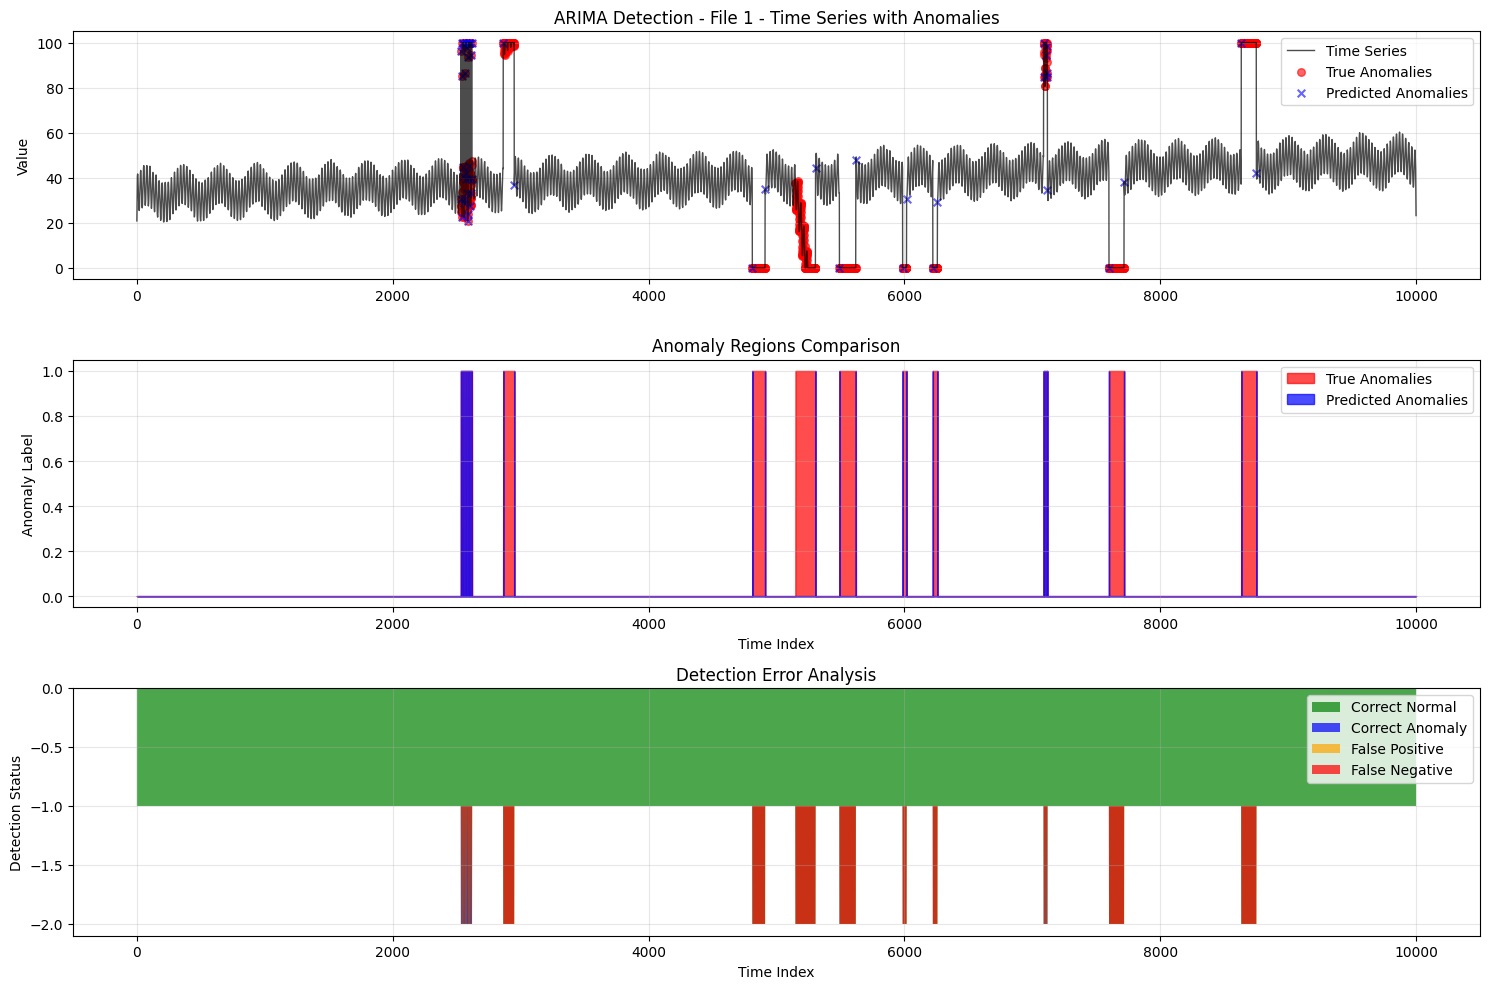

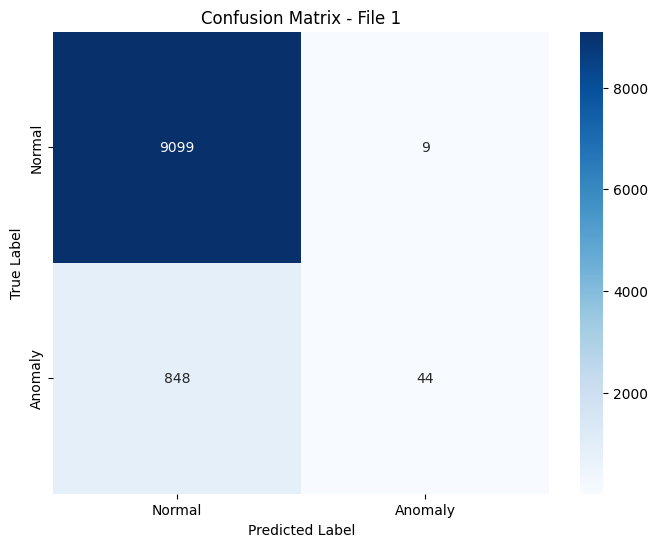



Processing File 2...
Best ARIMA parameters: (3, 1, 3)

EVALUATION RESULTS - FILE 2
Basic Metrics:
  Accuracy:  0.9003
  Precision: 0.9070
  Recall:    0.0731
  F1-Score:  0.1353

Anomaly Statistics:
  True Anomalies: 1067 points
  Predicted Anomalies: 86 points
  Detection Rate: 0.0731

Range-based Metrics:
  Range Precision: 0.9070
  Range Recall:    0.0731
  Range F1:        0.1326

Point-level Performance:
  True Positives:  78 points
  False Positives: 8 points
  False Negatives: 989 points

Segment Detection Metrics:
  Total Anomaly Segments: 10
  Fully Detected: 0
  Partially Detected: 6
  Missed: 4
  Segment Detection Rate: 0.0000
  Overall Detection Rate: 0.6000


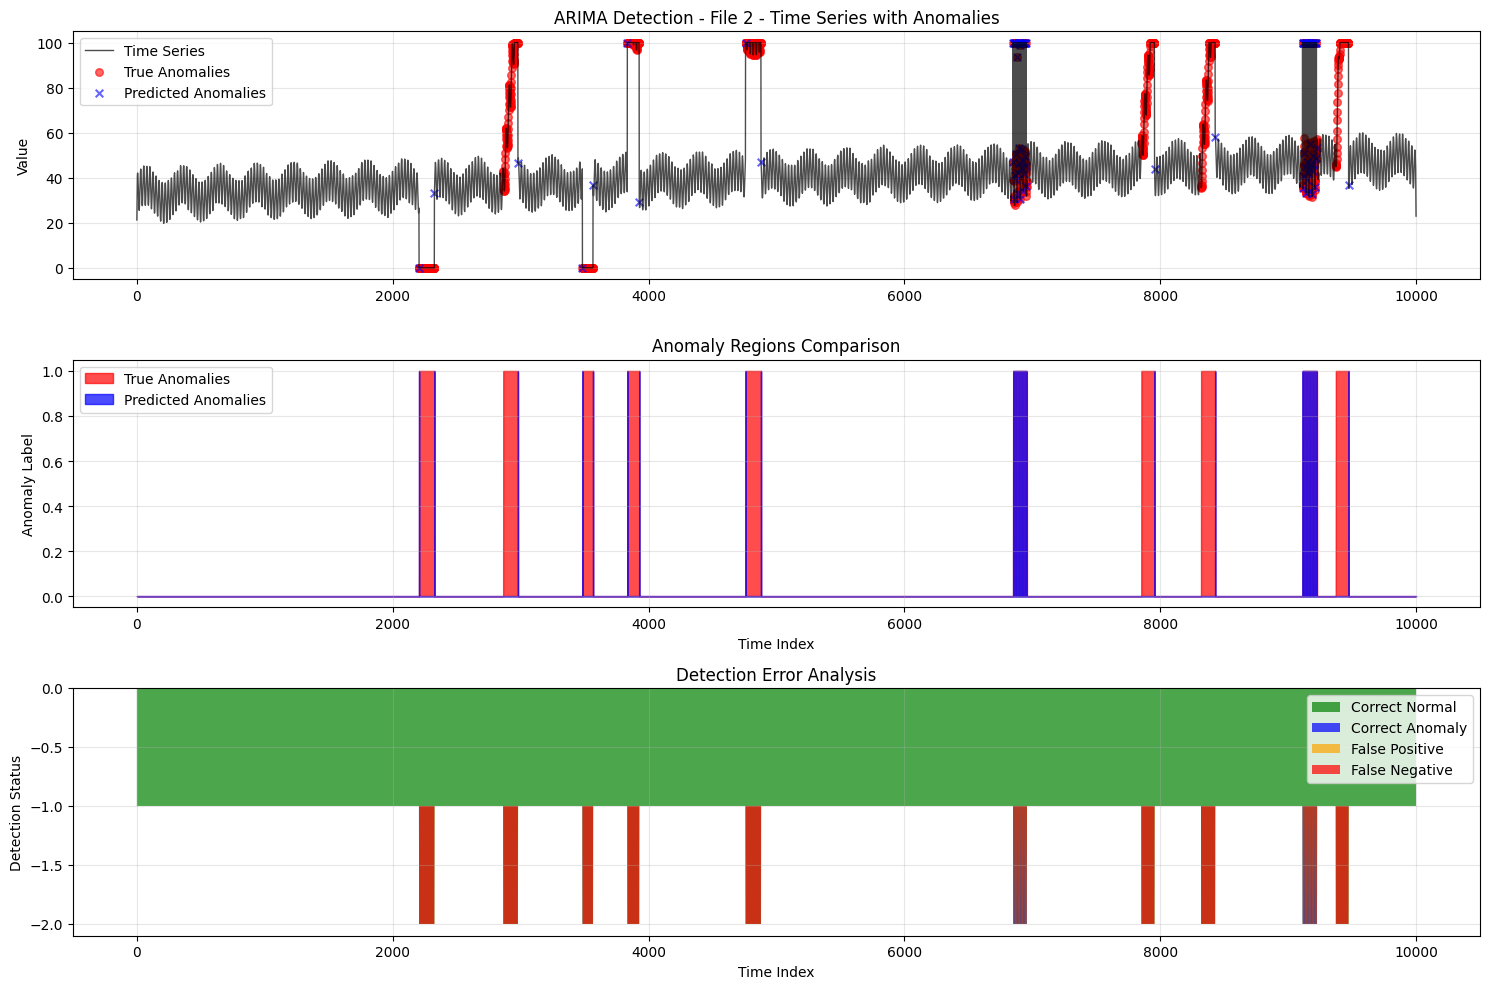

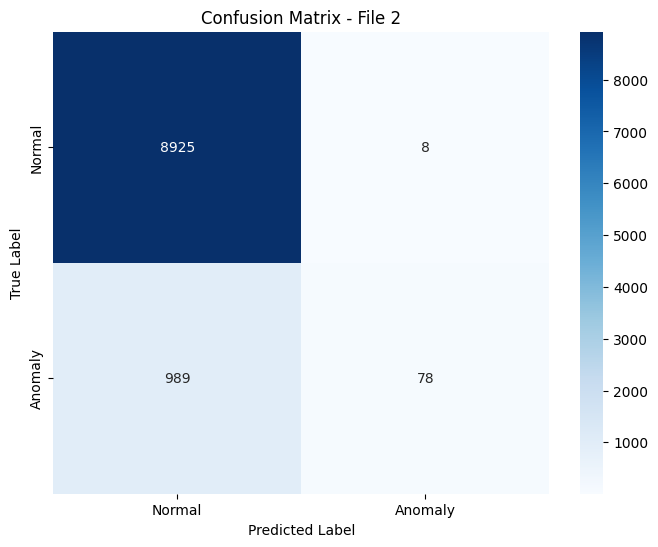



Processing File 3...
Best ARIMA parameters: (3, 1, 3)

EVALUATION RESULTS - FILE 3
Basic Metrics:
  Accuracy:  0.9309
  Precision: 0.9346
  Recall:    0.1276
  F1-Score:  0.2245

Anomaly Statistics:
  True Anomalies: 784 points
  Predicted Anomalies: 107 points
  Detection Rate: 0.1276

Range-based Metrics:
  Range Precision: 0.9346
  Range Recall:    0.1276
  Range F1:        0.2245

Point-level Performance:
  True Positives:  100 points
  False Positives: 7 points
  False Negatives: 684 points

Segment Detection Metrics:
  Total Anomaly Segments: 10
  Fully Detected: 0
  Partially Detected: 7
  Missed: 3
  Segment Detection Rate: 0.0000
  Overall Detection Rate: 0.7000


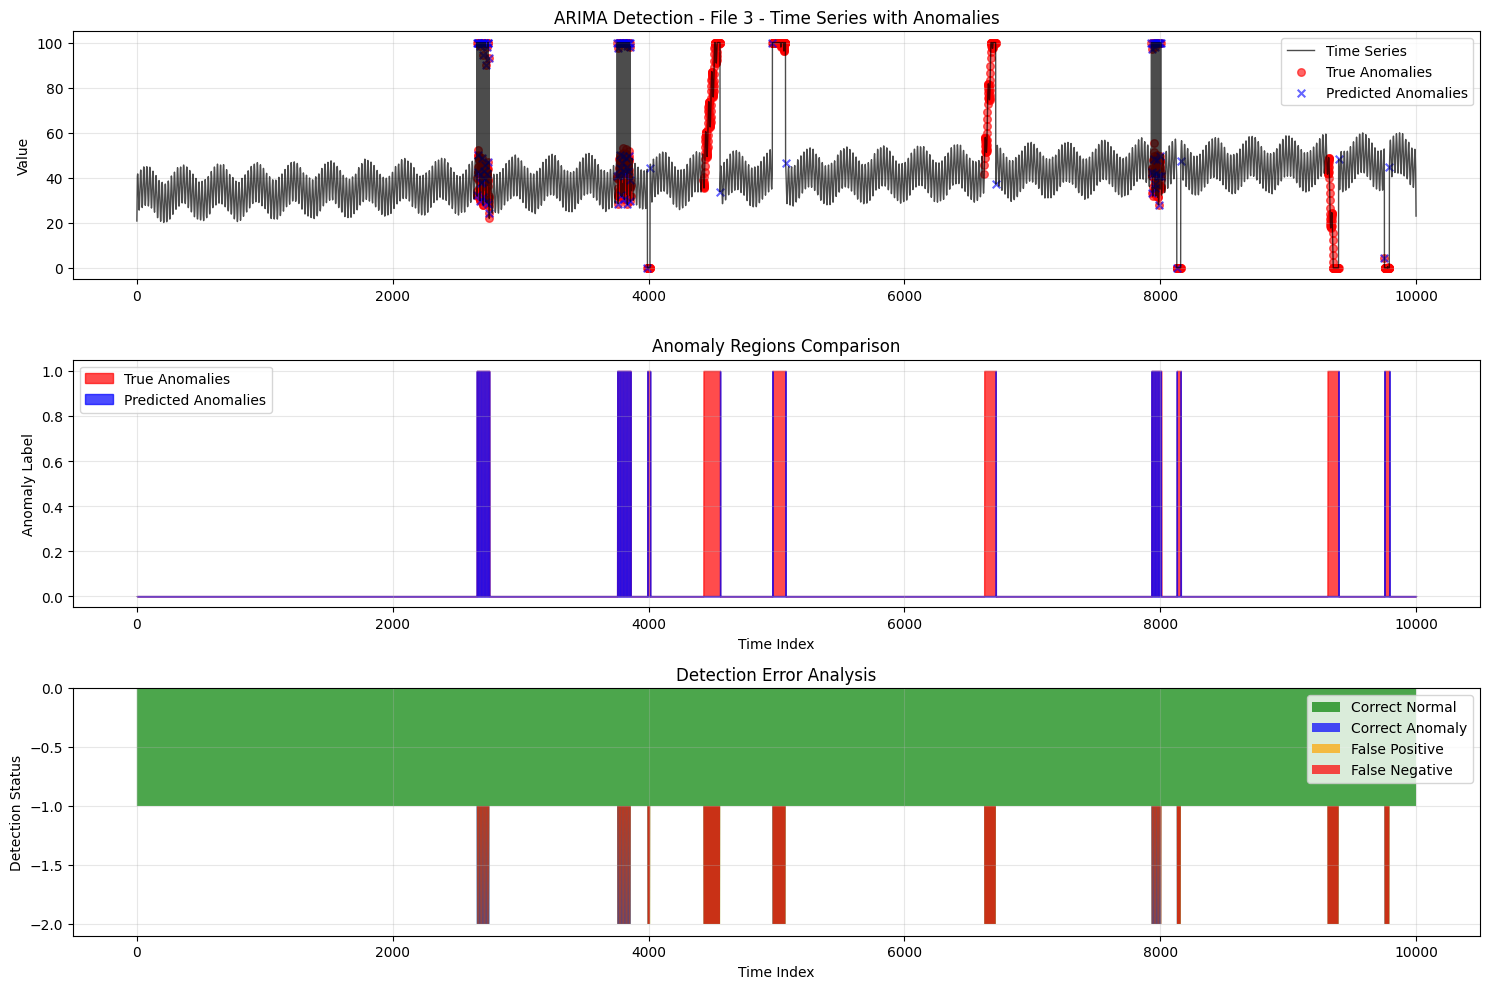

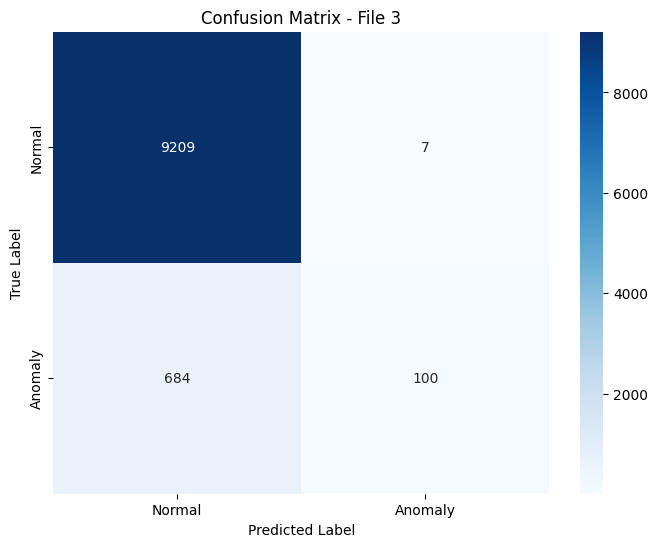



Processing File 4...
Best ARIMA parameters: (3, 1, 3)

EVALUATION RESULTS - FILE 4
Basic Metrics:
  Accuracy:  0.9261
  Precision: 0.8916
  Recall:    0.0920
  F1-Score:  0.1669

Anomaly Statistics:
  True Anomalies: 804 points
  Predicted Anomalies: 83 points
  Detection Rate: 0.0920

Range-based Metrics:
  Range Precision: 0.8916
  Range Recall:    0.0920
  Range F1:        0.1641

Point-level Performance:
  True Positives:  74 points
  False Positives: 9 points
  False Negatives: 730 points

Segment Detection Metrics:
  Total Anomaly Segments: 10
  Fully Detected: 0
  Partially Detected: 8
  Missed: 2
  Segment Detection Rate: 0.0000
  Overall Detection Rate: 0.8000


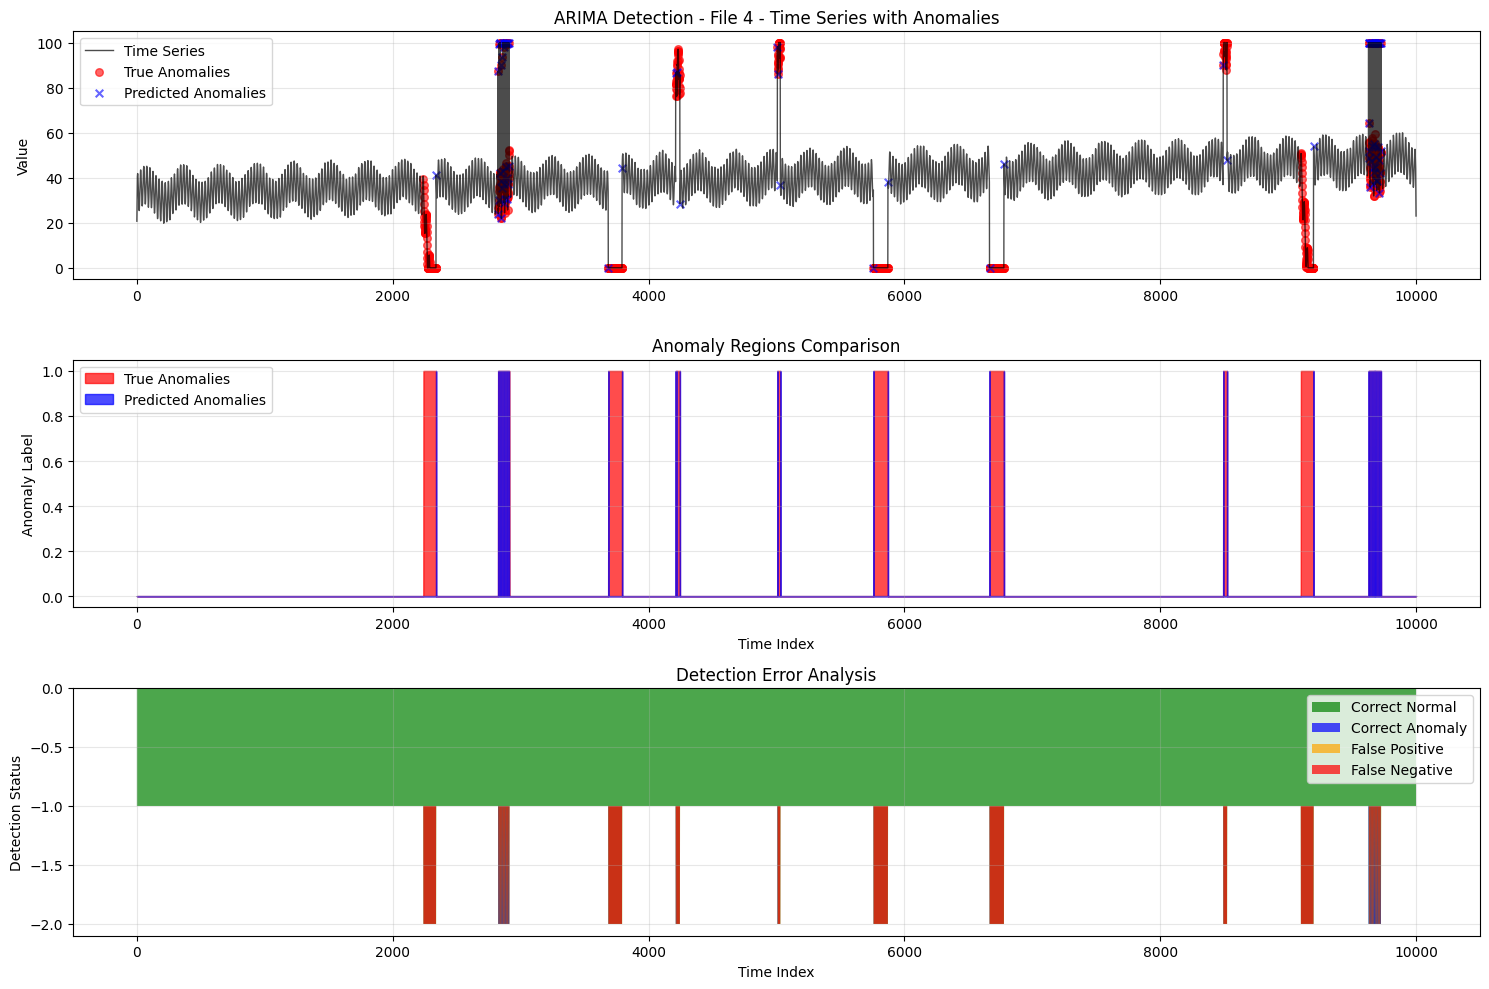

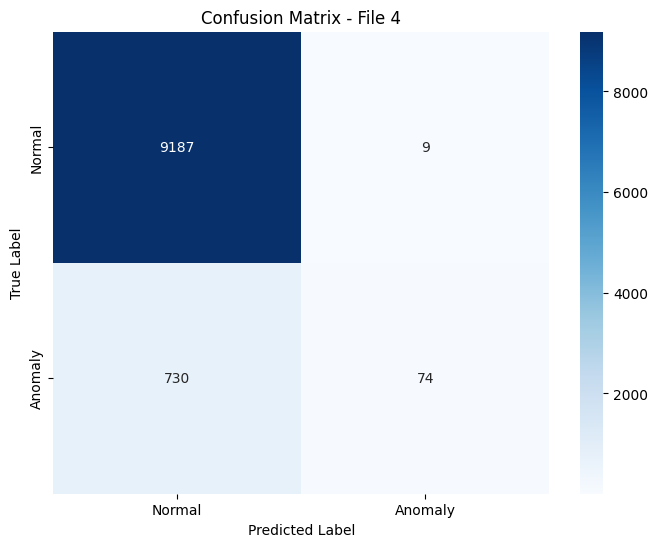



Processing File 5...
Best ARIMA parameters: (3, 1, 3)

EVALUATION RESULTS - FILE 5
Basic Metrics:
  Accuracy:  0.9537
  Precision: 0.8462
  Recall:    0.1083
  F1-Score:  0.1920

Anomaly Statistics:
  True Anomalies: 508 points
  Predicted Anomalies: 65 points
  Detection Rate: 0.1083

Range-based Metrics:
  Range Precision: 0.8462
  Range Recall:    0.1083
  Range F1:        0.1832

Point-level Performance:
  True Positives:  55 points
  False Positives: 10 points
  False Negatives: 453 points

Segment Detection Metrics:
  Total Anomaly Segments: 10
  Fully Detected: 0
  Partially Detected: 9
  Missed: 1
  Segment Detection Rate: 0.0000
  Overall Detection Rate: 0.9000


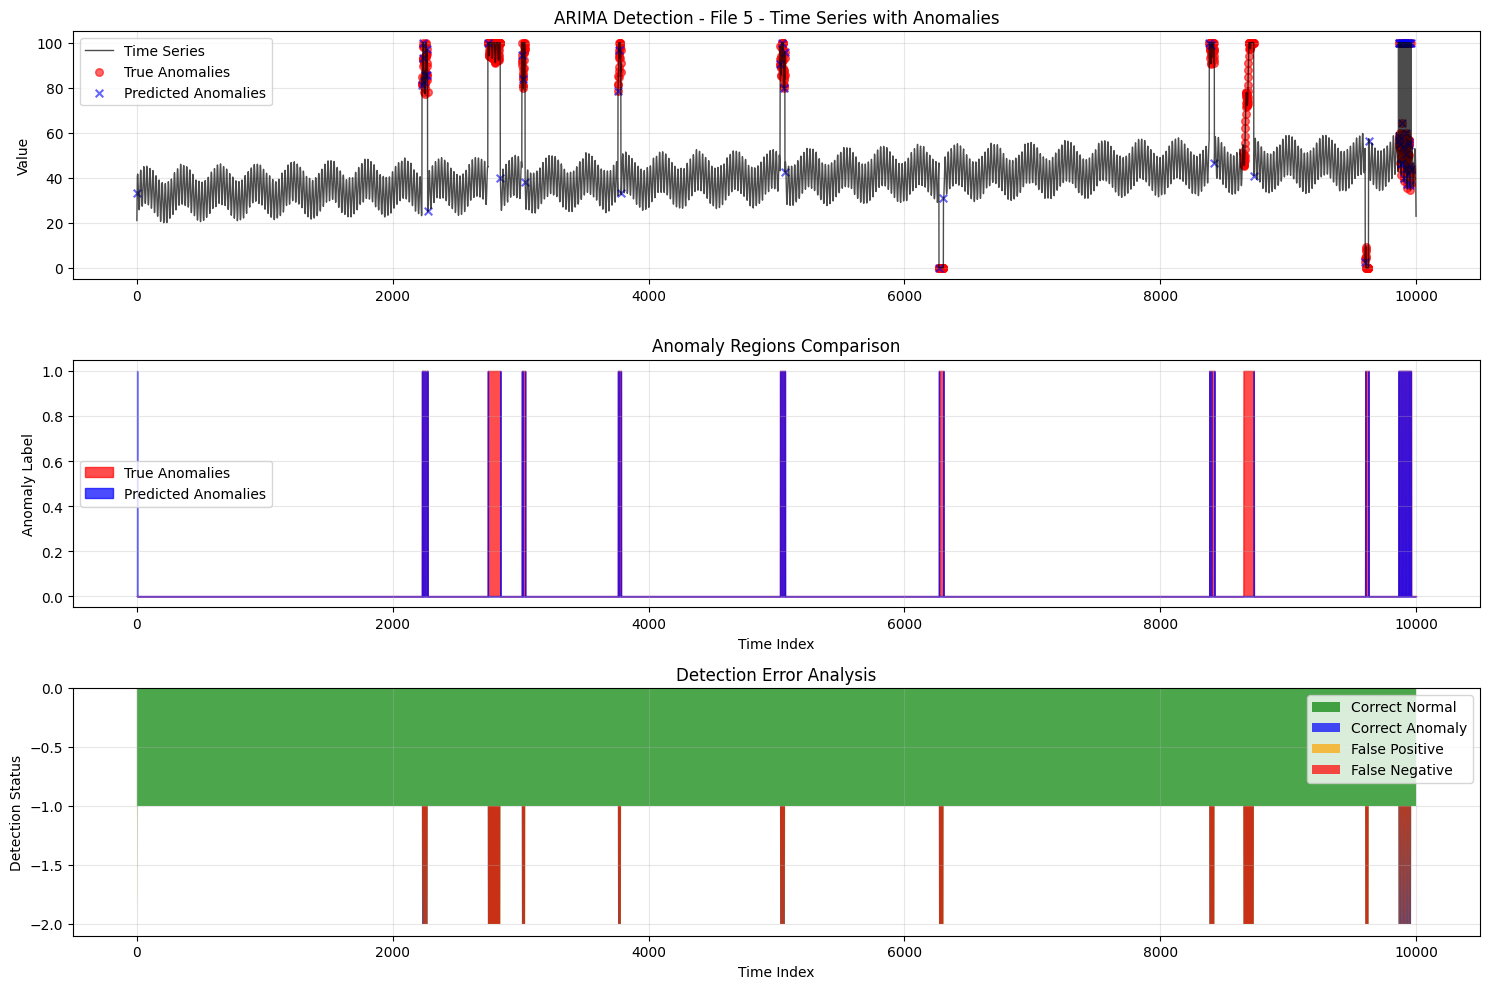

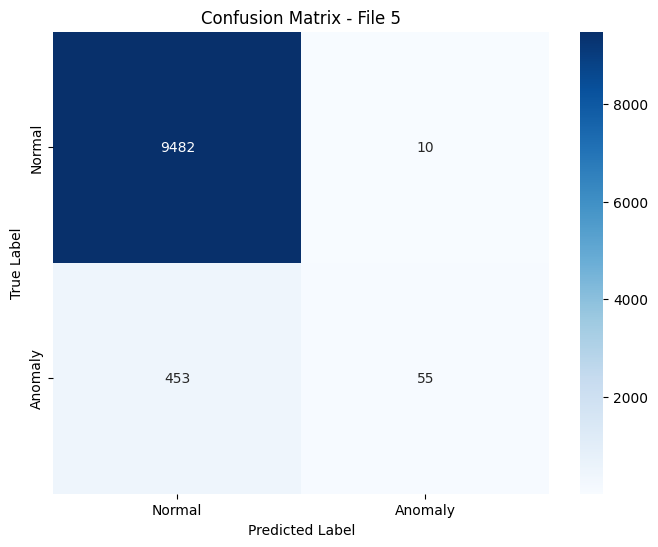



Processing File 6...
Best ARIMA parameters: (3, 1, 3)

EVALUATION RESULTS - FILE 6
Basic Metrics:
  Accuracy:  0.9096
  Precision: 0.9237
  Recall:    0.1086
  F1-Score:  0.1943

Anomaly Statistics:
  True Anomalies: 1004 points
  Predicted Anomalies: 118 points
  Detection Rate: 0.1086

Range-based Metrics:
  Range Precision: 0.9237
  Range Recall:    0.1086
  Range F1:        0.1943

Point-level Performance:
  True Positives:  109 points
  False Positives: 9 points
  False Negatives: 895 points

Segment Detection Metrics:
  Total Anomaly Segments: 10
  Fully Detected: 0
  Partially Detected: 8
  Missed: 2
  Segment Detection Rate: 0.0000
  Overall Detection Rate: 0.8000


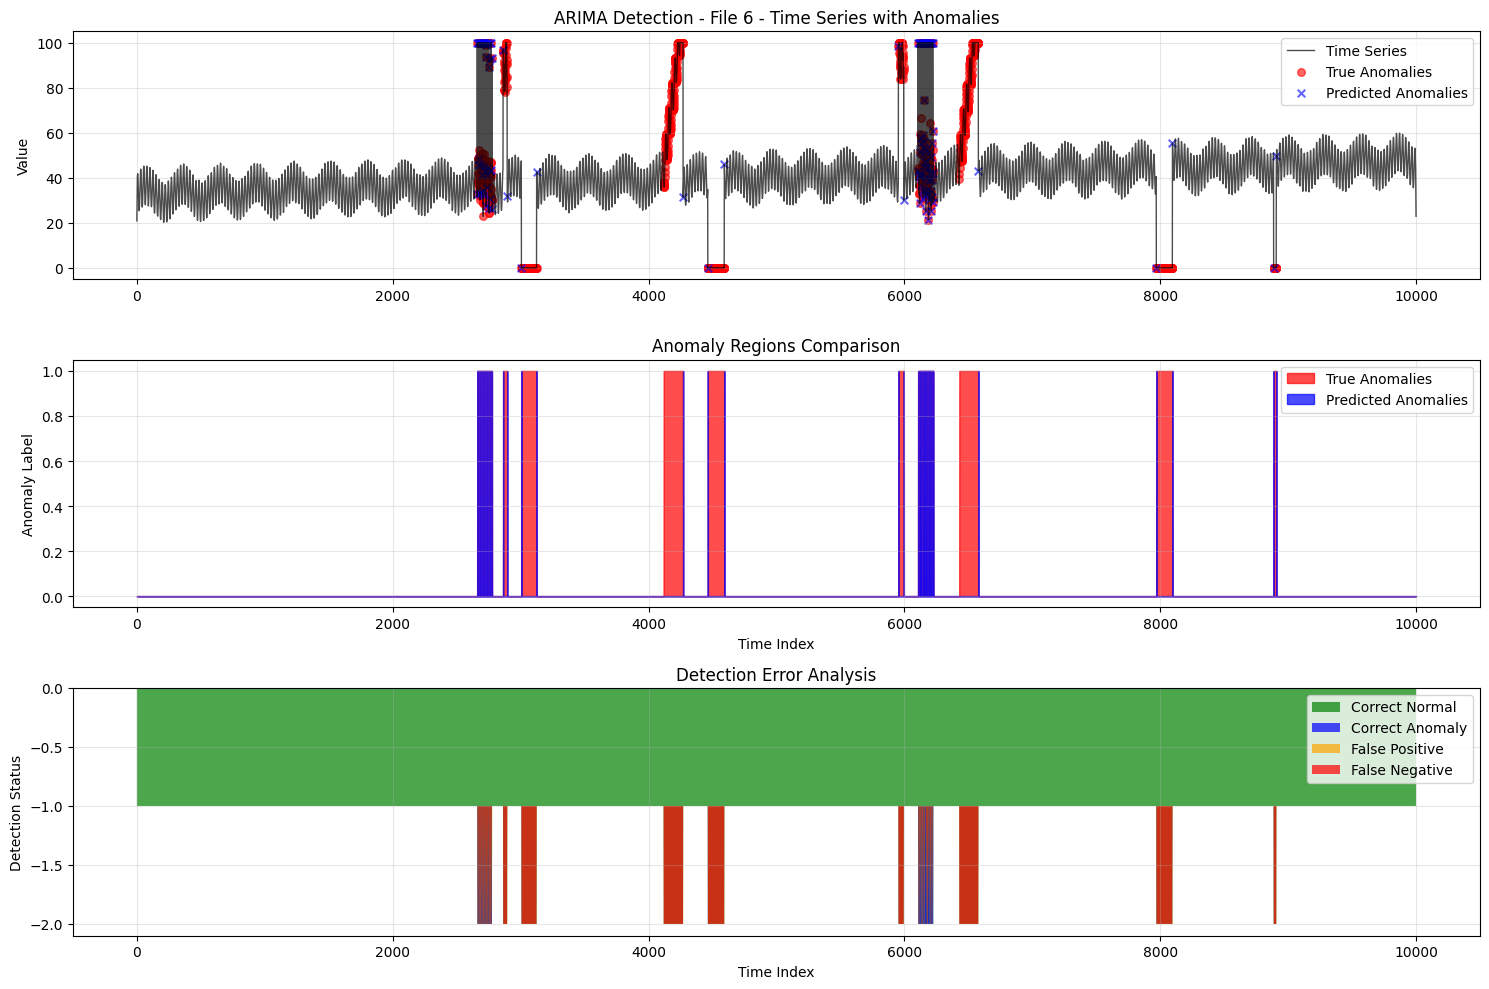

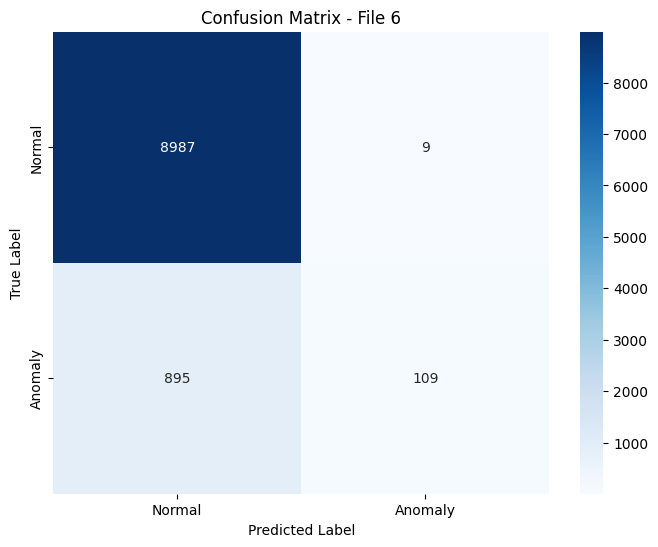



Processing File 7...
Best ARIMA parameters: (2, 1, 2)

EVALUATION RESULTS - FILE 7
Basic Metrics:
  Accuracy:  0.9216
  Precision: 0.7547
  Recall:    0.0493
  F1-Score:  0.0926

Anomaly Statistics:
  True Anomalies: 811 points
  Predicted Anomalies: 53 points
  Detection Rate: 0.0493

Range-based Metrics:
  Range Precision: 0.7547
  Range Recall:    0.0493
  Range F1:        0.0744

Point-level Performance:
  True Positives:  40 points
  False Positives: 13 points
  False Negatives: 771 points

Segment Detection Metrics:
  Total Anomaly Segments: 10
  Fully Detected: 0
  Partially Detected: 7
  Missed: 3
  Segment Detection Rate: 0.0000
  Overall Detection Rate: 0.7000


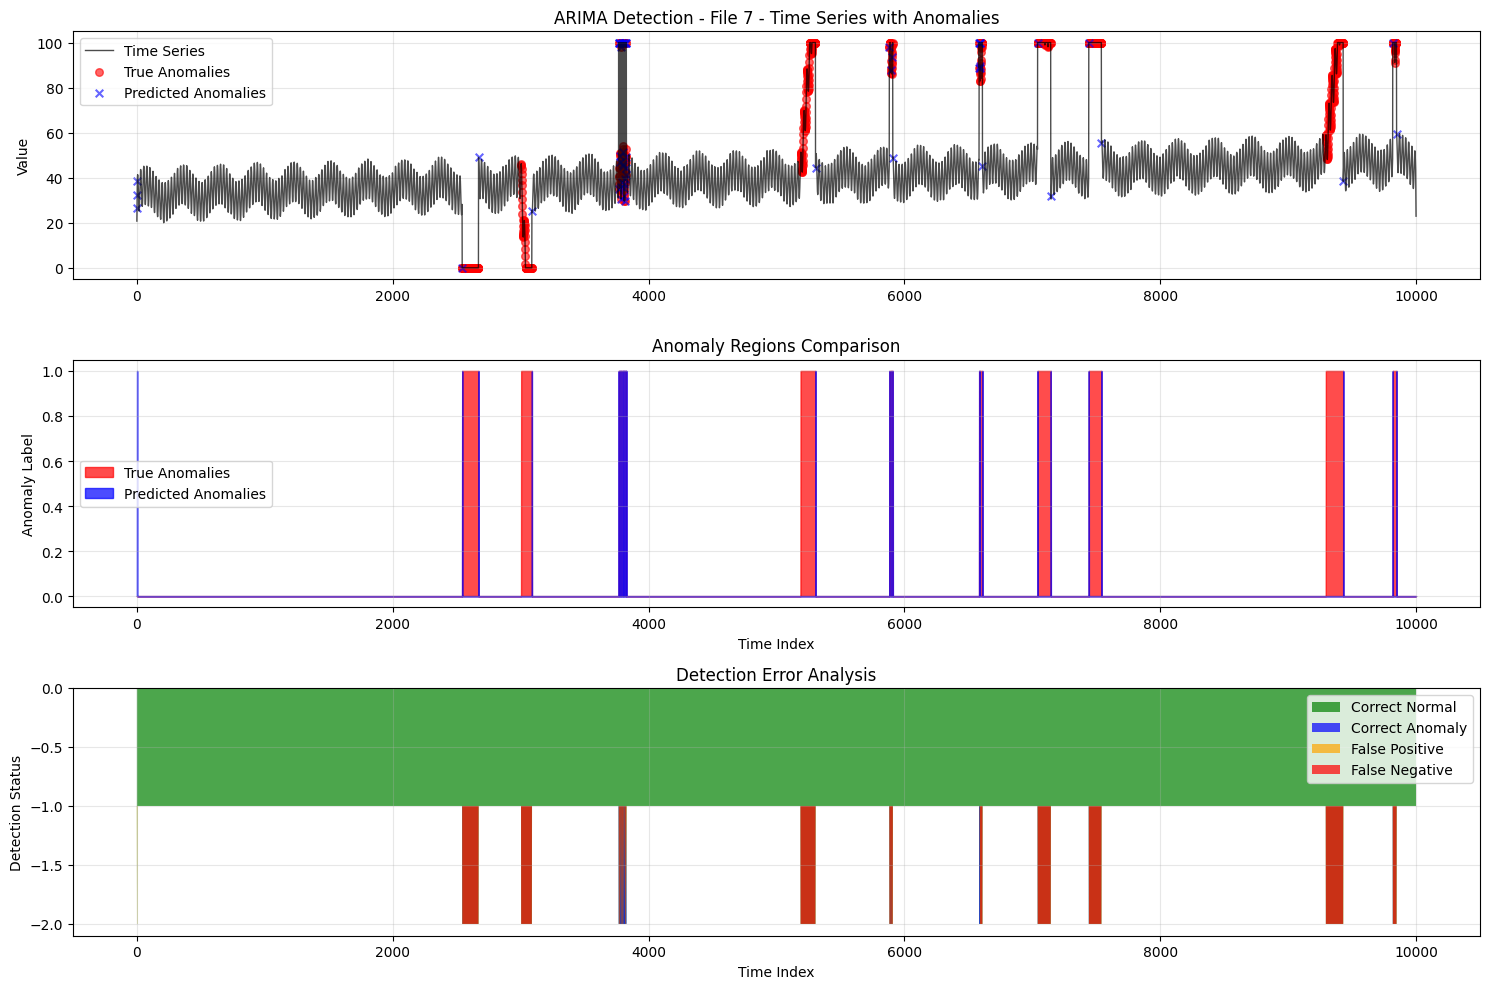

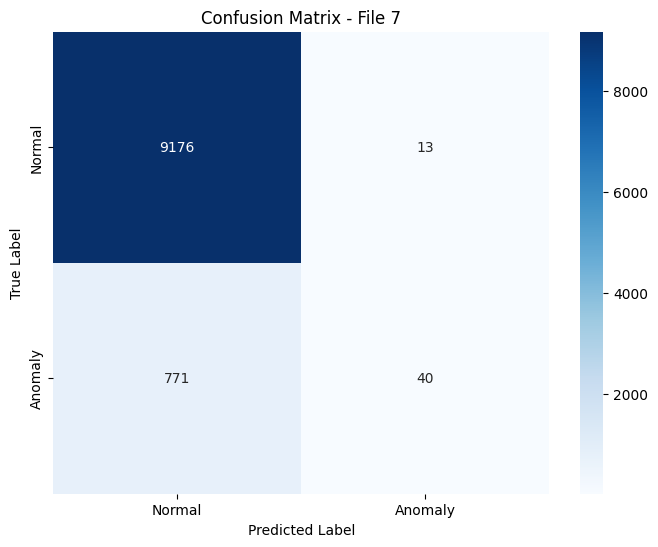



Processing File 8...
Best ARIMA parameters: (3, 1, 3)

EVALUATION RESULTS - FILE 8
Basic Metrics:
  Accuracy:  0.9151
  Precision: 0.9307
  Recall:    0.1004
  F1-Score:  0.1813

Anomaly Statistics:
  True Anomalies: 936 points
  Predicted Anomalies: 101 points
  Detection Rate: 0.1004

Range-based Metrics:
  Range Precision: 0.9307
  Range Recall:    0.1004
  Range F1:        0.1813

Point-level Performance:
  True Positives:  94 points
  False Positives: 7 points
  False Negatives: 842 points

Segment Detection Metrics:
  Total Anomaly Segments: 10
  Fully Detected: 0
  Partially Detected: 6
  Missed: 4
  Segment Detection Rate: 0.0000
  Overall Detection Rate: 0.6000


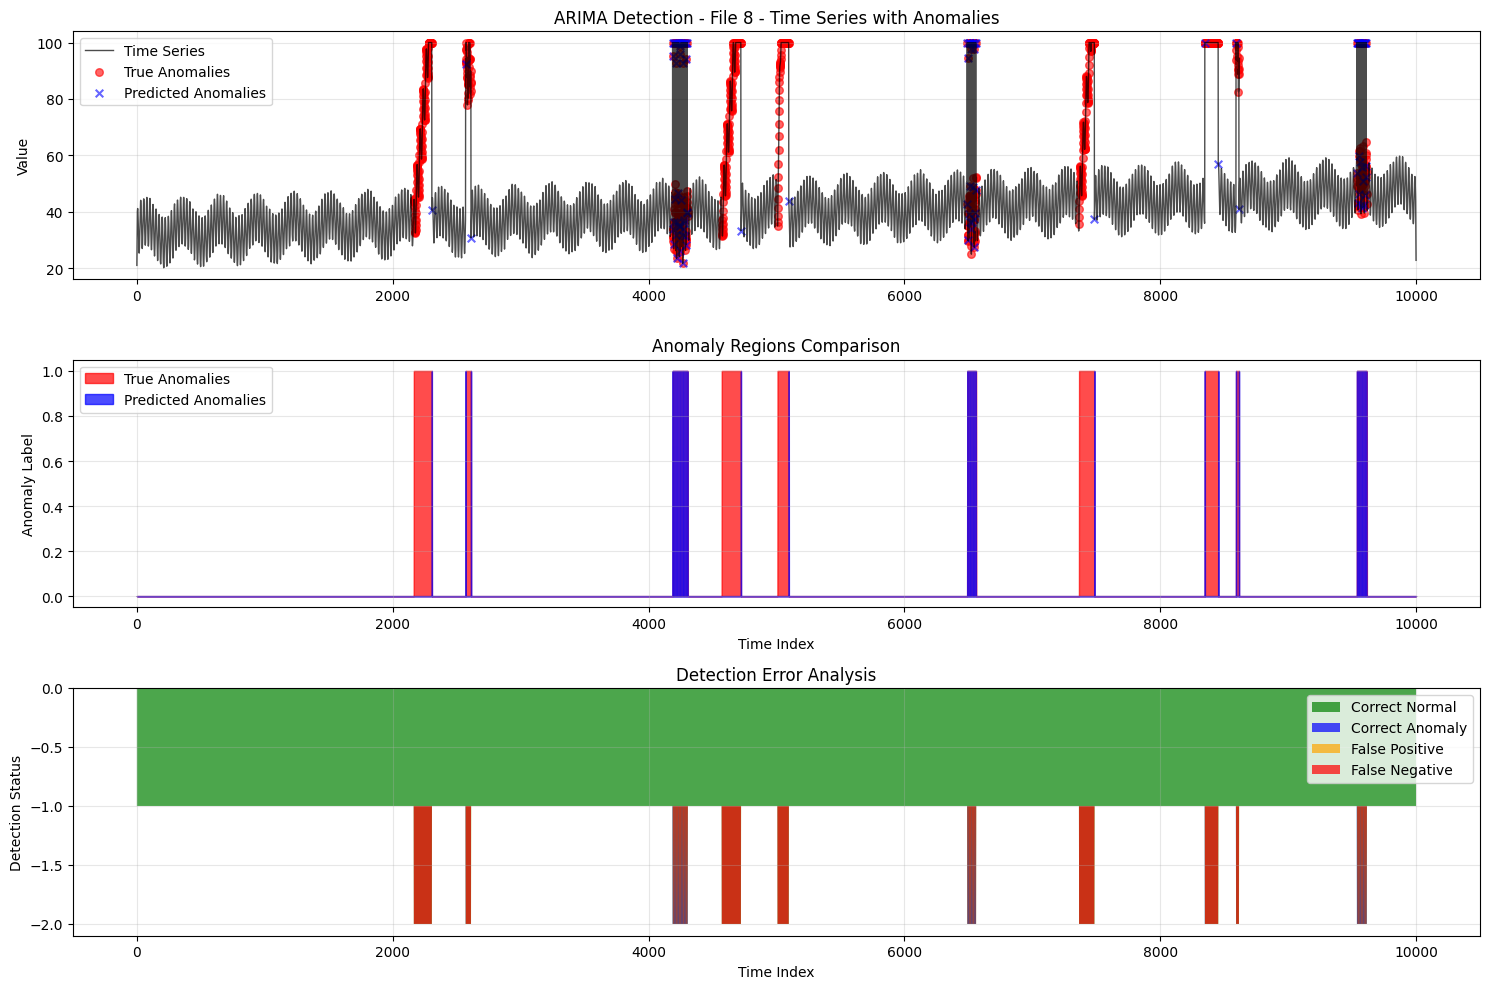

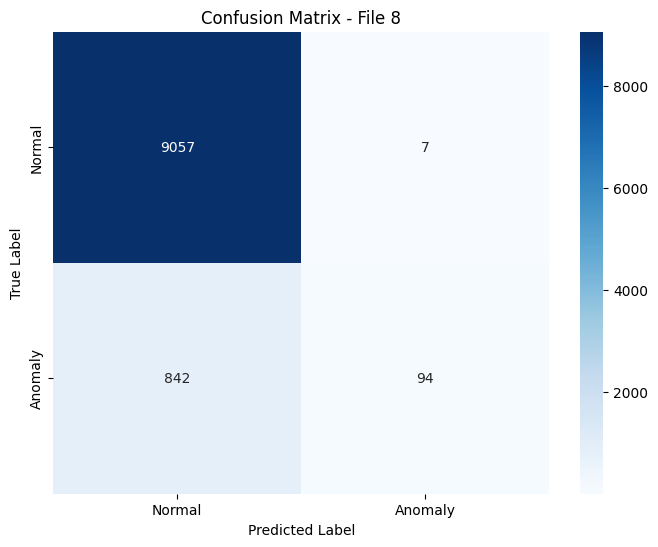



Processing File 9...
Best ARIMA parameters: (3, 1, 3)

EVALUATION RESULTS - FILE 9
Basic Metrics:
  Accuracy:  0.9353
  Precision: 0.9216
  Recall:    0.1282
  F1-Score:  0.2251

Anomaly Statistics:
  True Anomalies: 733 points
  Predicted Anomalies: 102 points
  Detection Rate: 0.1282

Range-based Metrics:
  Range Precision: 0.9216
  Range Recall:    0.1282
  Range F1:        0.2251

Point-level Performance:
  True Positives:  94 points
  False Positives: 8 points
  False Negatives: 639 points

Segment Detection Metrics:
  Total Anomaly Segments: 10
  Fully Detected: 0
  Partially Detected: 6
  Missed: 4
  Segment Detection Rate: 0.0000
  Overall Detection Rate: 0.6000


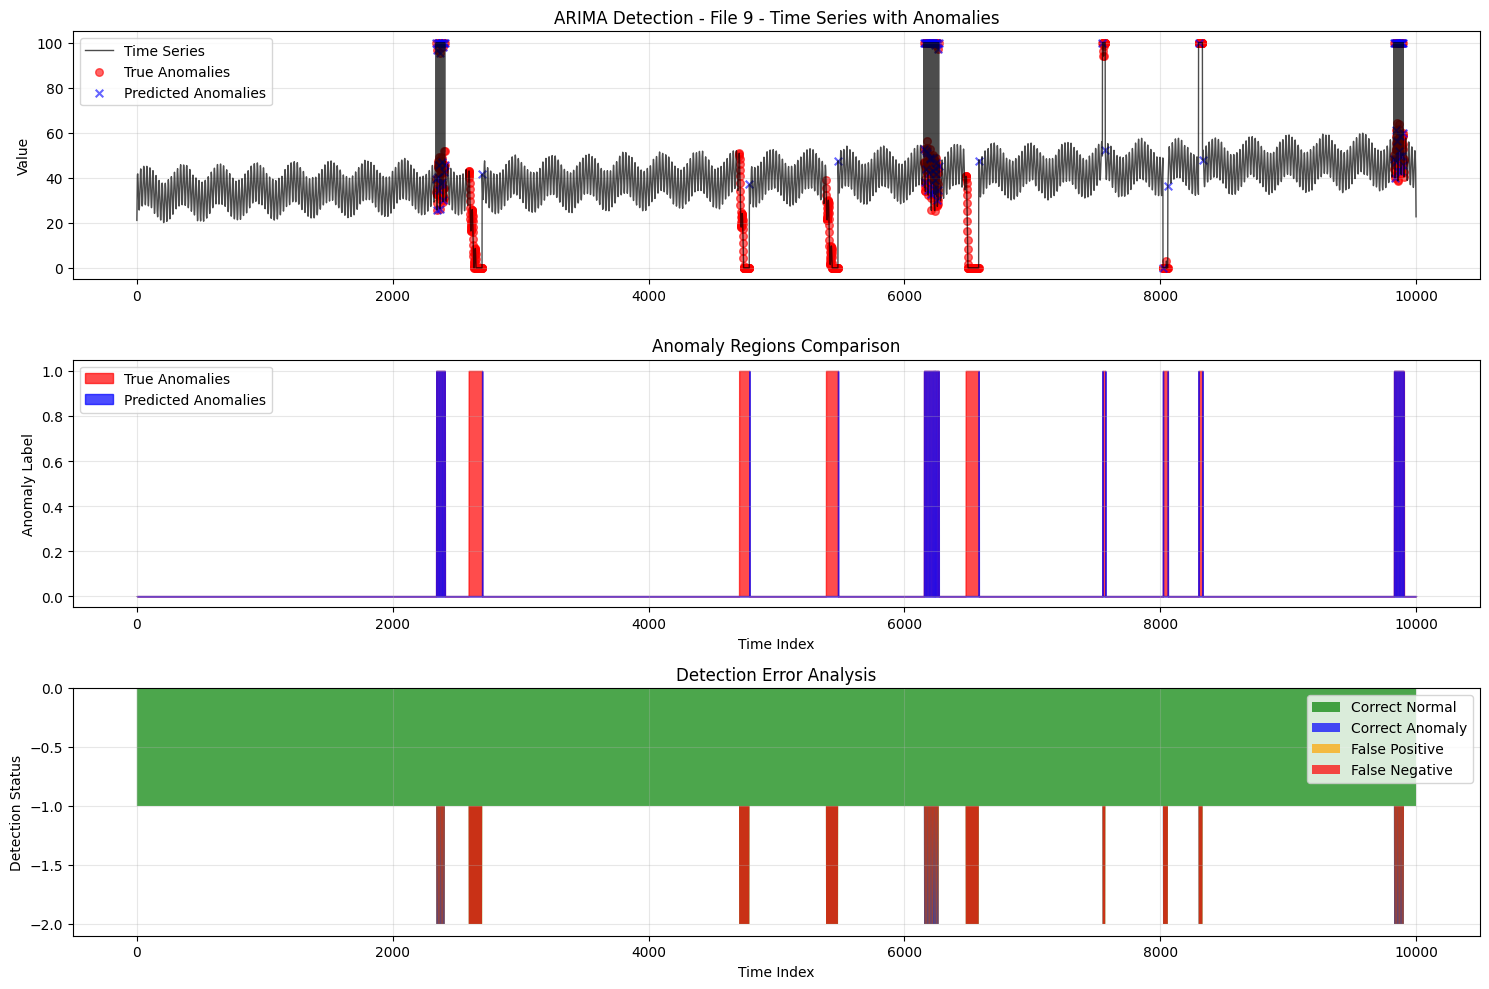

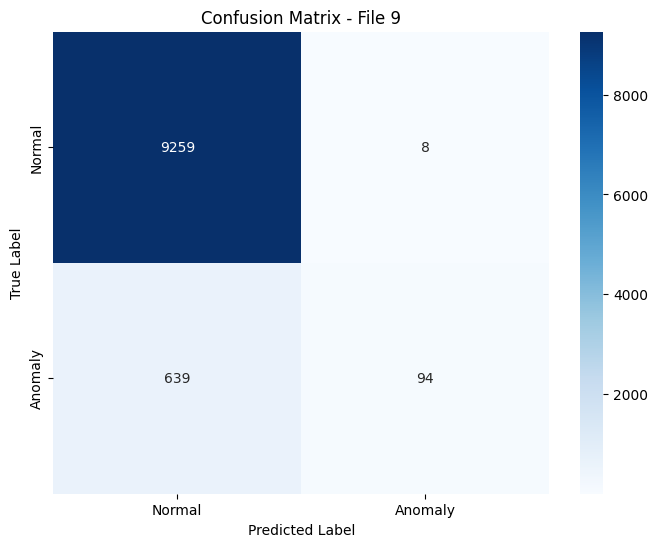



Processing File 10...
Best ARIMA parameters: (3, 1, 3)

EVALUATION RESULTS - FILE 10
Basic Metrics:
  Accuracy:  0.9045
  Precision: 0.8630
  Recall:    0.0625
  F1-Score:  0.1166

Anomaly Statistics:
  True Anomalies: 1008 points
  Predicted Anomalies: 73 points
  Detection Rate: 0.0625

Range-based Metrics:
  Range Precision: 0.8630
  Range Recall:    0.0625
  Range F1:        0.1079

Point-level Performance:
  True Positives:  63 points
  False Positives: 10 points
  False Negatives: 945 points

Segment Detection Metrics:
  Total Anomaly Segments: 10
  Fully Detected: 0
  Partially Detected: 6
  Missed: 4
  Segment Detection Rate: 0.0000
  Overall Detection Rate: 0.6000


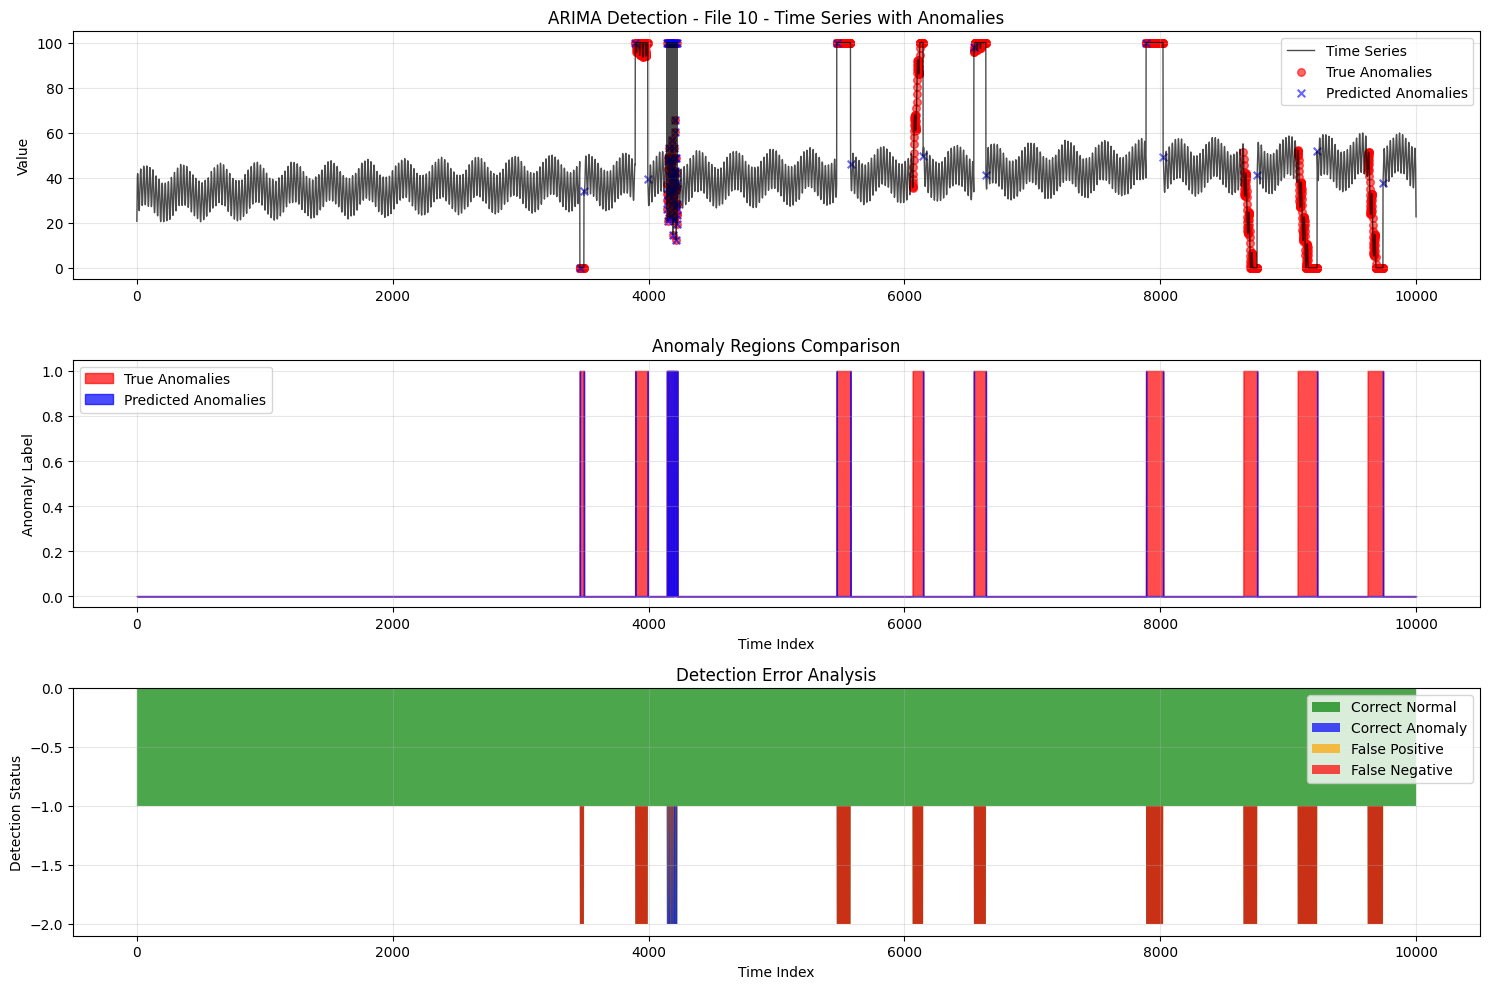

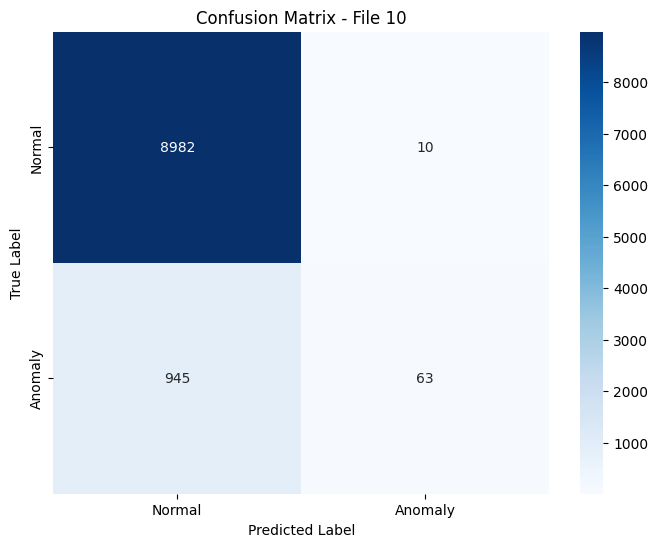


AGGREGATE PERFORMANCE ACROSS ALL FILES

Basic Metrics (Mean ± Std):
  Accuracy    : 0.9211 ± 0.0152
  Precision   : 0.8803 ± 0.0545
  Recall      : 0.0899 ± 0.0283
  F1_score    : 0.1622 ± 0.0475

Range-based Metrics (Mean ± Std):
  Range Precision: 0.8803 ± 0.0545
  Range Recall   : 0.0899 ± 0.0283
  Range F1       : 0.1569 ± 0.0523

Overall Anomaly Detection Rate: 0.0899

Performance Summary:
  Best F1-Score: 0.2251
  Worst F1-Score: 0.0926
  Average F1-Score: 0.1622
  Consistency (F1 Std): 0.0475


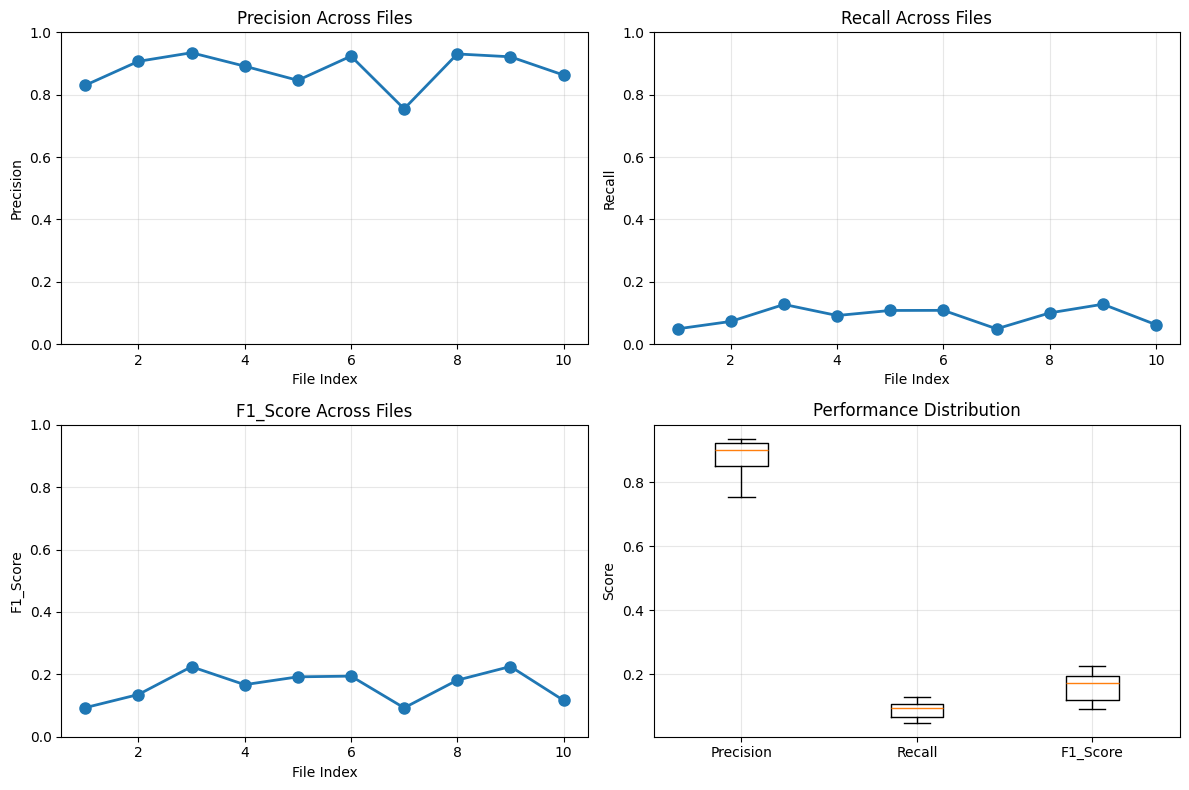


FINAL SUMMARY
ARIMA anomaly detection completed evaluation on 10 files.
Average F1-Score: 0.1622
Detection consistency: 0.0475 (lower is better)
POOR performance - Model struggles to detect anomalies accurately


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
import seaborn as sns
from collections import defaultdict

def evaluate_anomaly_detection_performance(true_labels, predicted_labels, anomaly_ranges=None, true_ranges=None):
    """
    Comprehensive evaluation of anomaly detection performance

    Parameters:
    - true_labels: ground truth labels (1 for anomaly, 0 for normal)
    - predicted_labels: predicted labels (1 for anomaly, 0 for normal)
    - anomaly_ranges: list of (start, end) tuples for predicted anomalies
    - true_ranges: list of (start, end) tuples for true anomalies
    """

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Basic classification metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=0)
    recall = recall_score(true_labels, predicted_labels, zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Calculate additional metrics for anomaly detection
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'true_anomalies': np.sum(true_labels),
        'predicted_anomalies': np.sum(predicted_labels),
        'detection_rate': np.sum(predicted_labels[true_labels == 1]) / max(1, np.sum(true_labels))
    }

    # Range-based evaluation if ranges are provided
    if anomaly_ranges and true_ranges:
        range_metrics = evaluate_anomaly_ranges(true_ranges, anomaly_ranges, len(true_labels))
        results.update(range_metrics)

    return results

def evaluate_anomaly_ranges(true_ranges, pred_ranges, total_length):
    """
    Evaluate performance based on anomaly ranges
    """
    # Convert ranges to binary masks for comparison
    true_mask = np.zeros(total_length, dtype=bool)
    pred_mask = np.zeros(total_length, dtype=bool)

    for start, end in true_ranges:
        true_mask[start:end+1] = True

    for start, end in pred_ranges:
        pred_mask[start:end+1] = True

    # Calculate overlap metrics
    true_positives = np.sum(true_mask & pred_mask)
    false_positives = np.sum(~true_mask & pred_mask)
    false_negatives = np.sum(true_mask & ~pred_mask)

    # Range-based precision and recall
    range_precision = true_positives / max(1, (true_positives + false_positives))
    range_recall = true_positives / max(1, (true_positives + false_negatives))
    range_f1 = 2 * (range_precision * range_recall) / max(1, (range_precision + range_recall))

    # Segment-based evaluation
    segment_metrics = evaluate_segment_detection(true_ranges, pred_ranges)

    return {
        'range_precision': range_precision,
        'range_recall': range_recall,
        'range_f1': range_f1,
        'true_positive_points': true_positives,
        'false_positive_points': false_positives,
        'false_negative_points': false_negatives,
        'segment_detection_metrics': segment_metrics
    }

def evaluate_segment_detection(true_ranges, pred_ranges, tolerance=5):
    """
    Evaluate how well entire anomaly segments are detected
    """
    detected_segments = []
    partially_detected_segments = []

    for true_start, true_end in true_ranges:
        true_length = true_end - true_start + 1
        segment_detected = False
        partial_overlap = False

        for pred_start, pred_end in pred_ranges:
            # Calculate overlap
            overlap_start = max(true_start, pred_start)
            overlap_end = min(true_end, pred_end)
            overlap_length = max(0, overlap_end - overlap_start + 1)

            # Check if segment is detected (significant overlap)
            if overlap_length >= max(1, true_length * 0.5):  # At least 50% overlap
                segment_detected = True
            elif overlap_length > 0:
                partial_overlap = True

        if segment_detected:
            detected_segments.append((true_start, true_end))
        elif partial_overlap:
            partially_detected_segments.append((true_start, true_end))

    total_segments = len(true_ranges)
    fully_detected = len(detected_segments)
    partially_detected = len(partially_detected_segments)
    missed_segments = total_segments - fully_detected - partially_detected

    return {
        'total_anomaly_segments': total_segments,
        'fully_detected_segments': fully_detected,
        'partially_detected_segments': partially_detected,
        'missed_segments': missed_segments,
        'segment_detection_rate': fully_detected / max(1, total_segments),
        'overall_detection_rate': (fully_detected + partially_detected) / max(1, total_segments)
    }

def plot_detection_results(true_labels, predicted_labels, series_values, title="Anomaly Detection Results"):
    """
    Plot comprehensive visualization of detection results
    """
    fig, axes = plt.subplots(3, 1, figsize=(15, 10))

    # Plot 1: Original series with true and predicted anomalies
    axes[0].plot(series_values, 'k-', alpha=0.7, linewidth=1, label='Time Series')

    # Plot true anomalies
    true_anomaly_indices = np.where(true_labels)[0]
    axes[0].scatter(true_anomaly_indices, series_values[true_anomaly_indices],
                   c='red', s=30, alpha=0.6, label='True Anomalies')

    # Plot predicted anomalies
    pred_anomaly_indices = np.where(predicted_labels)[0]
    axes[0].scatter(pred_anomaly_indices, series_values[pred_anomaly_indices],
                   c='blue', s=30, alpha=0.6, label='Predicted Anomalies', marker='x')

    axes[0].set_title(f'{title} - Time Series with Anomalies')
    axes[0].set_ylabel('Value')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Comparison of true vs predicted labels
    time_index = np.arange(len(true_labels))
    axes[1].fill_between(time_index, true_labels, alpha=0.7, color='red', label='True Anomalies')
    axes[1].fill_between(time_index, predicted_labels, alpha=0.7, color='blue', label='Predicted Anomalies')
    axes[1].set_title('Anomaly Regions Comparison')
    axes[1].set_ylabel('Anomaly Label')
    axes[1].set_xlabel('Time Index')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Error analysis (false positives/negatives)
    correct_normal = (~true_labels & ~predicted_labels).astype(int)
    correct_anomaly = (true_labels & predicted_labels).astype(int)
    false_positive = (~true_labels & predicted_labels).astype(int)
    false_negative = (true_labels & ~predicted_labels).astype(int)

    axes[2].stackplot(time_index, correct_normal, correct_anomaly, false_positive, false_negative,
                     labels=['Correct Normal', 'Correct Anomaly', 'False Positive', 'False Negative'],
                     colors=['green', 'blue', 'orange', 'red'], alpha=0.7)

    axes[2].set_title('Detection Error Analysis')
    axes[2].set_xlabel('Time Index')
    axes[2].set_ylabel('Detection Status')
    axes[2].legend(loc='upper right')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_heatmap(cm, title="Confusion Matrix"):
    """
    Plot a heatmap of the confusion matrix
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def print_detailed_metrics(results, file_idx=None):
    """
    Print comprehensive evaluation metrics
    """
    if file_idx:
        print(f"\n{'='*60}")
        print(f"EVALUATION RESULTS - FILE {file_idx}")
        print(f"{'='*60}")

    print(f"Basic Metrics:")
    print(f"  Accuracy:  {results['accuracy']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")
    print(f"  Recall:    {results['recall']:.4f}")
    print(f"  F1-Score:  {results['f1_score']:.4f}")

    print(f"\nAnomaly Statistics:")
    print(f"  True Anomalies: {results['true_anomalies']} points")
    print(f"  Predicted Anomalies: {results['predicted_anomalies']} points")
    print(f"  Detection Rate: {results['detection_rate']:.4f}")

    if 'range_precision' in results:
        print(f"\nRange-based Metrics:")
        print(f"  Range Precision: {results['range_precision']:.4f}")
        print(f"  Range Recall:    {results['range_recall']:.4f}")
        print(f"  Range F1:        {results['range_f1']:.4f}")

        print(f"\nPoint-level Performance:")
        print(f"  True Positives:  {results['true_positive_points']} points")
        print(f"  False Positives: {results['false_positive_points']} points")
        print(f"  False Negatives: {results['false_negative_points']} points")

    if 'segment_detection_metrics' in results:
        seg_metrics = results['segment_detection_metrics']
        print(f"\nSegment Detection Metrics:")
        print(f"  Total Anomaly Segments: {seg_metrics['total_anomaly_segments']}")
        print(f"  Fully Detected: {seg_metrics['fully_detected_segments']}")
        print(f"  Partially Detected: {seg_metrics['partially_detected_segments']}")
        print(f"  Missed: {seg_metrics['missed_segments']}")
        print(f"  Segment Detection Rate: {seg_metrics['segment_detection_rate']:.4f}")
        print(f"  Overall Detection Rate: {seg_metrics['overall_detection_rate']:.4f}")

# Main evaluation function for ARIMA anomaly detection
def evaluate_arima_detection_performance():
    """
    Comprehensive evaluation of ARIMA anomaly detection across all files
    """
    all_results = []
    detailed_metrics = defaultdict(list)

    print("COMPREHENSIVE ARIMA ANOMALY DETECTION EVALUATION")
    print("=" * 70)

    for idx, (train, test) in enumerate(zip(train_files, test_files), 1):
        print(f"\n\nProcessing File {idx}...")

        try:
            # Get true labels and series
            true_labels = test['Labels'].to_numpy().astype(int)
            series_values = test['Value1'].to_numpy()

            # Detect anomalies using ARIMA
            arima_detector = ARIMAAnomalyDetection()
            arima_detector.fit(train['Value1'].to_numpy())
            predicted_mask = arima_detector.detect_anomalies(series_values)

            # Convert mask to binary labels
            predicted_labels = predicted_mask.astype(int)

            # Get anomaly ranges for detailed evaluation
            true_ranges = []
            pred_ranges = []

            # Extract true anomaly ranges
            in_anomaly = False
            start_idx = 0
            for i, label in enumerate(true_labels):
                if label == 1 and not in_anomaly:
                    start_idx = i
                    in_anomaly = True
                elif label == 0 and in_anomaly:
                    true_ranges.append((start_idx, i-1))
                    in_anomaly = False
            if in_anomaly:
                true_ranges.append((start_idx, len(true_labels)-1))

            # Extract predicted anomaly ranges
            in_anomaly = False
            start_idx = 0
            for i, label in enumerate(predicted_labels):
                if label == 1 and not in_anomaly:
                    start_idx = i
                    in_anomaly = True
                elif label == 0 and in_anomaly:
                    pred_ranges.append((start_idx, i-1))
                    in_anomaly = False
            if in_anomaly:
                pred_ranges.append((start_idx, len(predicted_labels)-1))

            # Evaluate performance
            results = evaluate_anomaly_detection_performance(
                true_labels, predicted_labels, pred_ranges, true_ranges
            )

            # Store results
            all_results.append(results)

            # Print detailed metrics for this file
            print_detailed_metrics(results, file_idx=idx)

            # Plot results for this file
            plot_detection_results(true_labels, predicted_labels, series_values,
                                 title=f"ARIMA Detection - File {idx}")

            # Plot confusion matrix
            plot_confusion_matrix_heatmap(results['confusion_matrix'],
                                        title=f"Confusion Matrix - File {idx}")

            # Store metrics for aggregate analysis
            detailed_metrics['accuracy'].append(results['accuracy'])
            detailed_metrics['precision'].append(results['precision'])
            detailed_metrics['recall'].append(results['recall'])
            detailed_metrics['f1_score'].append(results['f1_score'])

            if 'range_precision' in results:
                detailed_metrics['range_precision'].append(results['range_precision'])
                detailed_metrics['range_recall'].append(results['range_recall'])
                detailed_metrics['range_f1'].append(results['range_f1'])

        except Exception as e:
            print(f"Error evaluating file {idx}: {e}")
            continue

    # Print aggregate performance
    print_aggregate_performance(detailed_metrics)

    return all_results, detailed_metrics

def print_aggregate_performance(detailed_metrics):
    """
    Print aggregate performance across all files
    """
    print("\n" + "="*70)
    print("AGGREGATE PERFORMANCE ACROSS ALL FILES")
    print("="*70)

    if not detailed_metrics:
        print("No results to display.")
        return

    print("\nBasic Metrics (Mean ± Std):")
    for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
        if metric in detailed_metrics and detailed_metrics[metric]:
            values = detailed_metrics[metric]
            print(f"  {metric.capitalize():<12}: {np.mean(values):.4f} ± {np.std(values):.4f}")

    print("\nRange-based Metrics (Mean ± Std):")
    for metric in ['range_precision', 'range_recall', 'range_f1']:
        if metric in detailed_metrics and detailed_metrics[metric]:
            values = detailed_metrics[metric]
            print(f"  {metric.replace('_', ' ').title():<15}: {np.mean(values):.4f} ± {np.std(values):.4f}")

    # Overall detection rate
    if 'recall' in detailed_metrics:
        overall_recall = np.mean(detailed_metrics['recall'])
        print(f"\nOverall Anomaly Detection Rate: {overall_recall:.4f}")

    # Performance summary
    print(f"\nPerformance Summary:")
    print(f"  Best F1-Score: {np.max(detailed_metrics['f1_score']):.4f}")
    print(f"  Worst F1-Score: {np.min(detailed_metrics['f1_score']):.4f}")
    print(f"  Average F1-Score: {np.mean(detailed_metrics['f1_score']):.4f}")
    print(f"  Consistency (F1 Std): {np.std(detailed_metrics['f1_score']):.4f}")

# Run the comprehensive evaluation
print("Starting comprehensive evaluation of ARIMA anomaly detection...")
all_results, aggregate_metrics = evaluate_arima_detection_performance()

# Additional visualization: Performance across files
def plot_performance_across_files(aggregate_metrics):
    """
    Plot performance metrics across all files
    """
    metrics_to_plot = ['precision', 'recall', 'f1_score']

    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics_to_plot, 1):
        if metric in aggregate_metrics:
            plt.subplot(2, 2, i)
            plt.plot(range(1, len(aggregate_metrics[metric]) + 1), aggregate_metrics[metric],
                    'o-', linewidth=2, markersize=8)
            plt.title(f'{metric.title()} Across Files')
            plt.xlabel('File Index')
            plt.ylabel(metric.title())
            plt.grid(True, alpha=0.3)
            plt.ylim(0, 1)

    # Overall performance box plot
    plt.subplot(2, 2, 4)
    box_data = [aggregate_metrics[metric] for metric in metrics_to_plot if metric in aggregate_metrics]
    plt.boxplot(box_data, labels=[metric.title() for metric in metrics_to_plot if metric in aggregate_metrics])
    plt.title('Performance Distribution')
    plt.ylabel('Score')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot performance across files
if aggregate_metrics:
    plot_performance_across_files(aggregate_metrics)

    # Print final summary
    print("\n" + "="*70)
    print("FINAL SUMMARY")
    print("="*70)
    print(f"ARIMA anomaly detection completed evaluation on {len(aggregate_metrics['f1_score'])} files.")
    print(f"Average F1-Score: {np.mean(aggregate_metrics['f1_score']):.4f}")
    print(f"Detection consistency: {np.std(aggregate_metrics['f1_score']):.4f} (lower is better)")

    if np.mean(aggregate_metrics['f1_score']) > 0.7:
        print("GOOD performance - Model effectively detects anomalies")
    elif np.mean(aggregate_metrics['f1_score']) > 0.5:
        print("MODERATE performance - Model detects some anomalies but needs improvement")
    else:
        print("POOR performance - Model struggles to detect anomalies accurately")